<a href="https://colab.research.google.com/github/mezkymy/ecommerce-ds/blob/dev-mez/Final_Project_DS_Rakamin_Batch_31_Kelompok_4_(Cobra).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 12.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 4.3 MB/s eta 0:00:00


In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import skew
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, jaccard_score, log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

import shap

import warnings 
warnings.filterwarnings('ignore')

In [ ]:
# initialize random state
random_state = 25

# set plot style for whole notebook
sns.set_style('white')
sns.set_context('paper')

In [ ]:
# load csv file, create raw data (original copy) and dataframe (df) to manipulate
raw_data = pd.read_csv('https://raw.githubusercontent.com/mezkymy/ecommerce-ds/main/Train.csv')
df = raw_data.copy()
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


# 1. Data Exploration

Source: [E-Commerce Shipping Data from Kaggle](https://www.kaggle.com/datasets/prachi13/customer-analytics)

## Context (copied from Kaggle):
An international e-commerce company based wants to discover key insights from their customer database. They want to use some of the most advanced machine learning techniques to study their customers. The company sells electronic products.

## 1.1 Descriptive Statistics Analysis

In [ ]:
# check columns and null/non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


Keterangan kolom (dicopy dari Kaggle):

    ID: ID Number of Customers.
    Warehouse block: The Company have big Warehouse which is divided in to block such as A,B,C,D,E.
    Mode of shipment:The Company Ships the products in multiple way such as Ship, Flight and Road.
    Customer care calls: The number of calls made from enquiry for enquiry of the shipment.
    Customer rating: The company has rated from every customer. 1 is the lowest (Worst), 5 is the highest (Best).
    Cost of the product: Cost of the Product in US Dollars.
    Prior purchases: The Number of Prior Purchase.
    Product importance: The company has categorized the product in the various parameter such as low, medium, high.
    Gender: Male and Female.
    Discount offered: Discount offered on that specific product.
    Weight in gms: It is the weight in grams.
    Reached on time: It is the target variable, where 1 Indicates that the product has NOT reached on time and 0 indicates it has reached on time.

Perlu diperhatikan bahwa untuk kolom target (`Reached.on.Time_Y.N`) angka 1 justru melambangkan <b>pengiriman yang terlambat</b> (tidak <i>reached on time</i>). Agar pemahaman terkait kolom lebih intuitif, nama kolom akan diubah menjadi `Late_delivery`. 

In [ ]:
# change target column name
df = df.rename({'Reached.on.Time_Y.N': 'Late_delivery'}, axis='columns')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Late_delivery        10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


<b>Tidak ada kolom yang terdeteksi memiliki null value.</b>

In [ ]:
# check if any ID is duplicated
df[df['ID'].duplicated()]

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Late_delivery


<b>Tidak ada ID duplikat terdeteksi.</b>

Kolom ID dapat di-drop karena tidak akan digunakan pada tahapan selanjutnya.

In [ ]:
# drop ID column
df.drop('ID', axis=1, inplace=True)
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Late_delivery
0,D,Flight,4,2,177,3,low,F,44,1233,1
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1
3,B,Flight,3,3,176,4,medium,M,10,1177,1
4,C,Flight,2,2,184,3,medium,F,46,2484,1


In [ ]:
# descriptive statistics for numerical values
df.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Late_delivery
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


Terdapat sebuah kejanggalan pada feature `Discount_offered`, dimana nilai maksimalnya sebesar 65 sedangkan selisih jaraknya dengan Q3 (10) atau mean (13) sangat tinggi, sehingga diduga terdapat beberapa outlier/pencilan data yang mungkin perlu ditangani, atau memang data sangat terpusat di range tertentu.

In [ ]:
# descriptive for categorical columns
categoricals = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
df[categoricals].describe()

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
count,10999,10999,10999,10999
unique,5,3,3,2
top,F,Ship,low,F
freq,3666,7462,5297,5545


Tidak terdapat kejanggalan pada data kategorikal karena setiap kolom memiliki jumlah data yang sama dengan jumlah total baris data dan tidak terdapat nilai yang tidak diharapkan seperti huruf atau karakter yang dianggap sebagai kejanggalan.

## 1.2 Univariate Analysis


### 1.2.1 Pemeriksaan Rasio Data Target

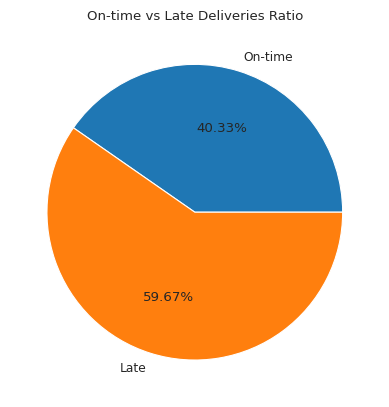

In [ ]:
# check ratio of on-time vs late deliveries
df.groupby('Late_delivery').size().plot(kind='pie', labels=['On-time', 'Late'], autopct='%.2f%%')

plt.title('On-time vs Late Deliveries Ratio')
plt.show()

Melalui grafik di atas, dapat diketahui bahwa proporsi pengiriman yang tepat waktu (On-time) sebesar 40,33% dan proporsi pengiriman yang terlambat (Late) sebesar 59,67%. Angka ini konsisten dengan nilai rata-rata/mean dari target, dimana mean = persentase pengiriman yang terlambat. Dapat disimpulkan bahwa lebih banyak pengiriman yang mengalami keterlambatan dibandingkan pengiriman yang tepat waktu. Hal ini dapat menjadi fokus perbaikan untuk meningkatkan kualitas layanan dan kepuasan pelanggan.

Karena data sudah memiliki jumlah sampel yang cukup banyak dan tidak terlalu berbeda antara kelas satu dengan yang lain (tidak terlalu signifikan <i>class imbalance</i>-nya), maka tidak perlu dilakukan penyeimbangan lebih lanjut terhadap pada tahap pre-processing data.

### 1.2.2. Pemeriksaan Sebaran Data untuk Tiap Fitur/Variabel

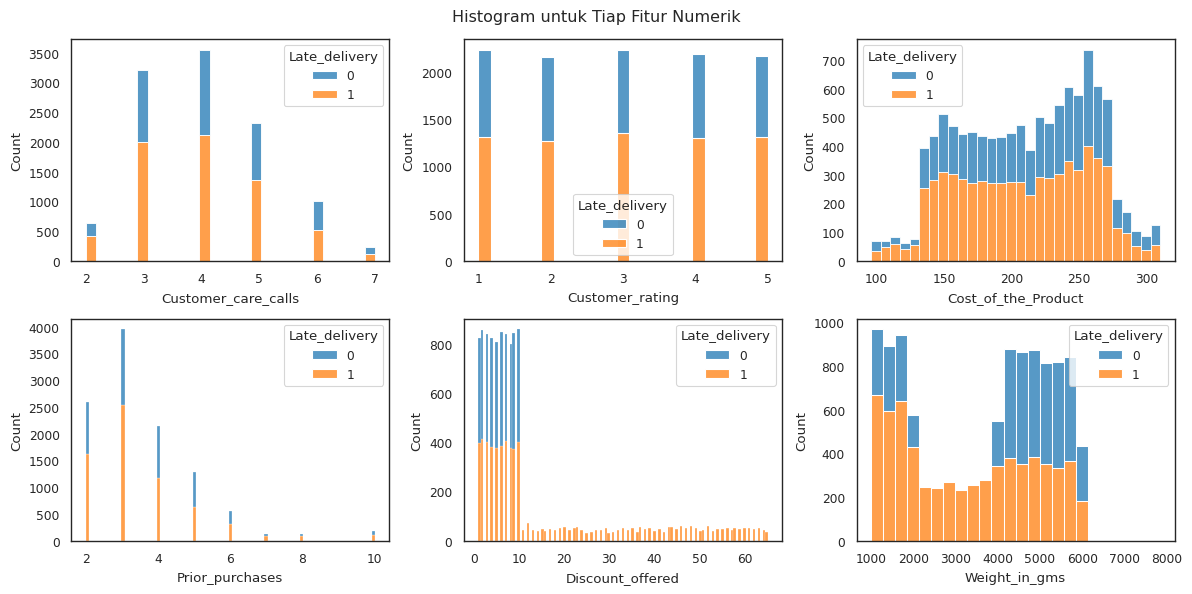

In [ ]:
# histogram for numeric columns
numeric_columns = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

plt.suptitle('Histogram untuk Tiap Fitur Numerik')

i = 0
for y in axes:
    for ax in y:
        column = numeric_columns[i]
        sns.histplot(df, x=column, hue='Late_delivery', multiple='stack', ax=ax)
        ax.minorticks_on()
        i += 1

fig.tight_layout(pad=1)
plt.show()

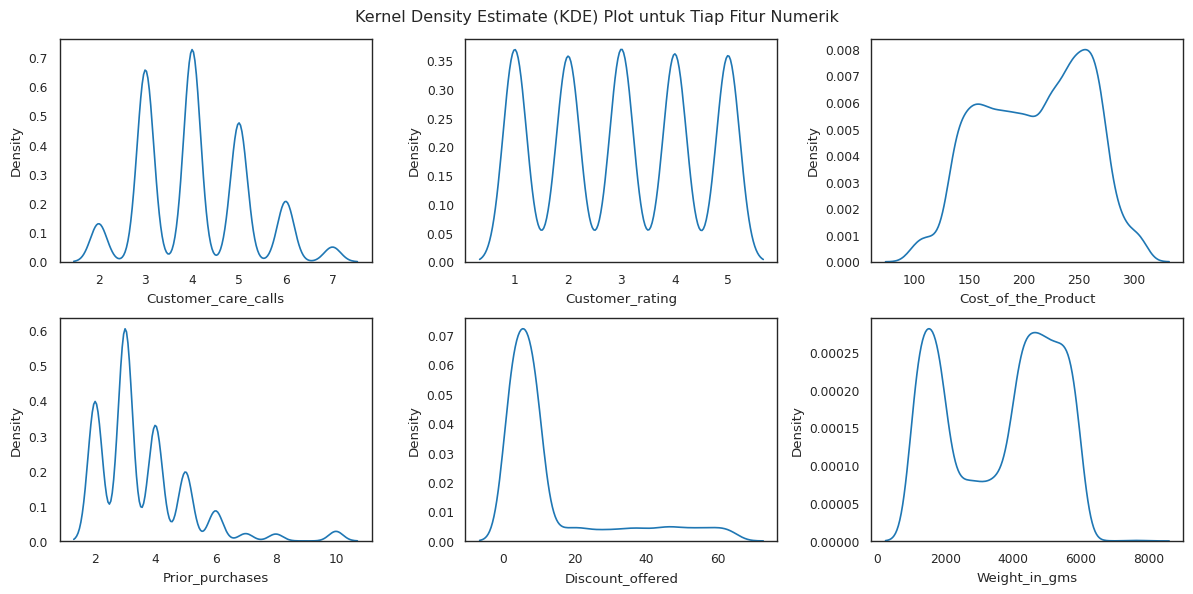

In [ ]:
# KDEplot for numeric columns (sebagai pembanding tampilan)
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

plt.suptitle('Kernel Density Estimate (KDE) Plot untuk Tiap Fitur Numerik')

i = 0
for y in axes:
    for ax in y:
        column = numeric_columns[i]
        sns.kdeplot(df, x=column, ax=ax)
        ax.minorticks_on()
        i += 1

fig.tight_layout(pad=1)
plt.show()

Pada grafik sebaran fitur numerik terdapat beberapa hal yang menarik, diantaranya yaitu:

- Sebaran data berdasarkan fitur `Prior_purchase` membentuk positive skew
- Pada sebaran data berdasarkan fitur `Weight_in_gms` terdapat beberapa outlier pada nilai diatas 6000 (tidak terlalu terlihat pada grafik)
- Pada sebaran data berdasarkan fitur `Discount_offered`, terdapat secara jelas nilai yang mendominasi yaitu pada nilai 0 - 10%, dan <b>barang yang diberikan diskon di luar range tersebut tidak ada yang sampai tepat waktu</b>


Saat data pre-processing, perlu dilakukan scaling/standarisasi pada data numerik agar mempunyai range yang seragam.

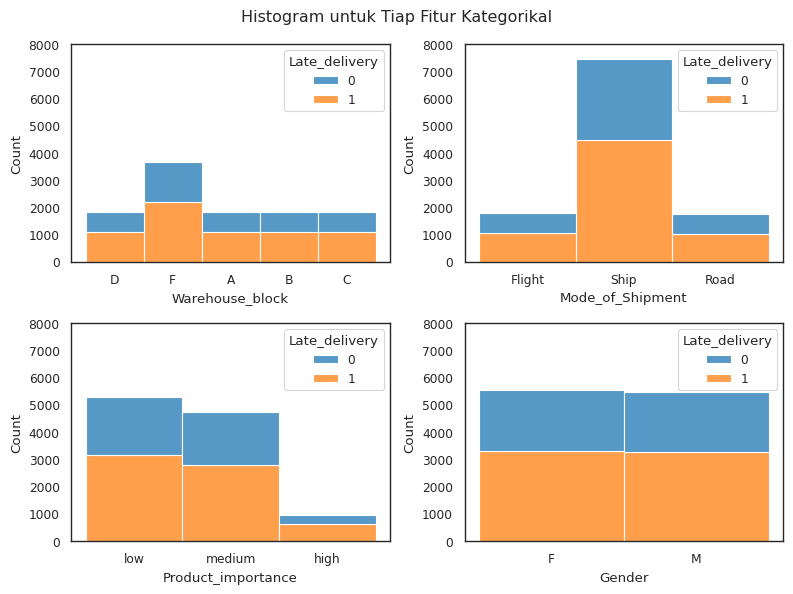

In [ ]:
# Create histplot for categorical columns
categorical_columns = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

plt.suptitle('Histogram untuk Tiap Fitur Kategorikal')

i = 0
for y in axes:
    for ax in y:
        column = categorical_columns[i]
        sns.histplot(df, x=column, hue='Late_delivery', multiple='stack', ax=ax) 
        ax.set_ylim(0, 8000)
        i += 1

fig.tight_layout(pad=1)
plt.show()

Insight Histogram Fitur Kategorikal:

- Berdasarkan Warehouse, barang paling banyak disimpan/dilayani oleh Warehouse F, sedangkan warehouse lainnya kurang lebih menampung jumlah barang yang sama
- Mayoritas pengiriman dilakukan melalui jalur laut (Ship)
- Jumlah barang yang tingkat kepentingannya tinggi (high) relatif sedikit
- Jumlah customer pria hampir setara dengan jumlah customer wanita, dengan rasio keterlambatan yang juga serupa
- Beberapa hal yang perlu ditindaklanjuti pada saat data pre-processing:
  - Untuk kolom `Gender`, dapat dilakukan mapping agar nilai "M" dan "F" menjadi 0 dan 1.
  - Untuk kolom `Product_importance`, dapat dilakukan label encoding karena kedua kolom tersebut memiliki nilai-nilai yang berurutan dan memiliki hubungan ordinal antara nilai-nilainya.
  - Untuk kolom `Warehouse_block` dan `Mode_of_Shipment`, dapat dilakukan one-hot encoding karena kolom tersebut tidak memiliki hubungan ordinal antara nilai-nilainya dan setiap nilai kategorikal dianggap sama pentingnya.




## 1.3 Multivariate Analysis

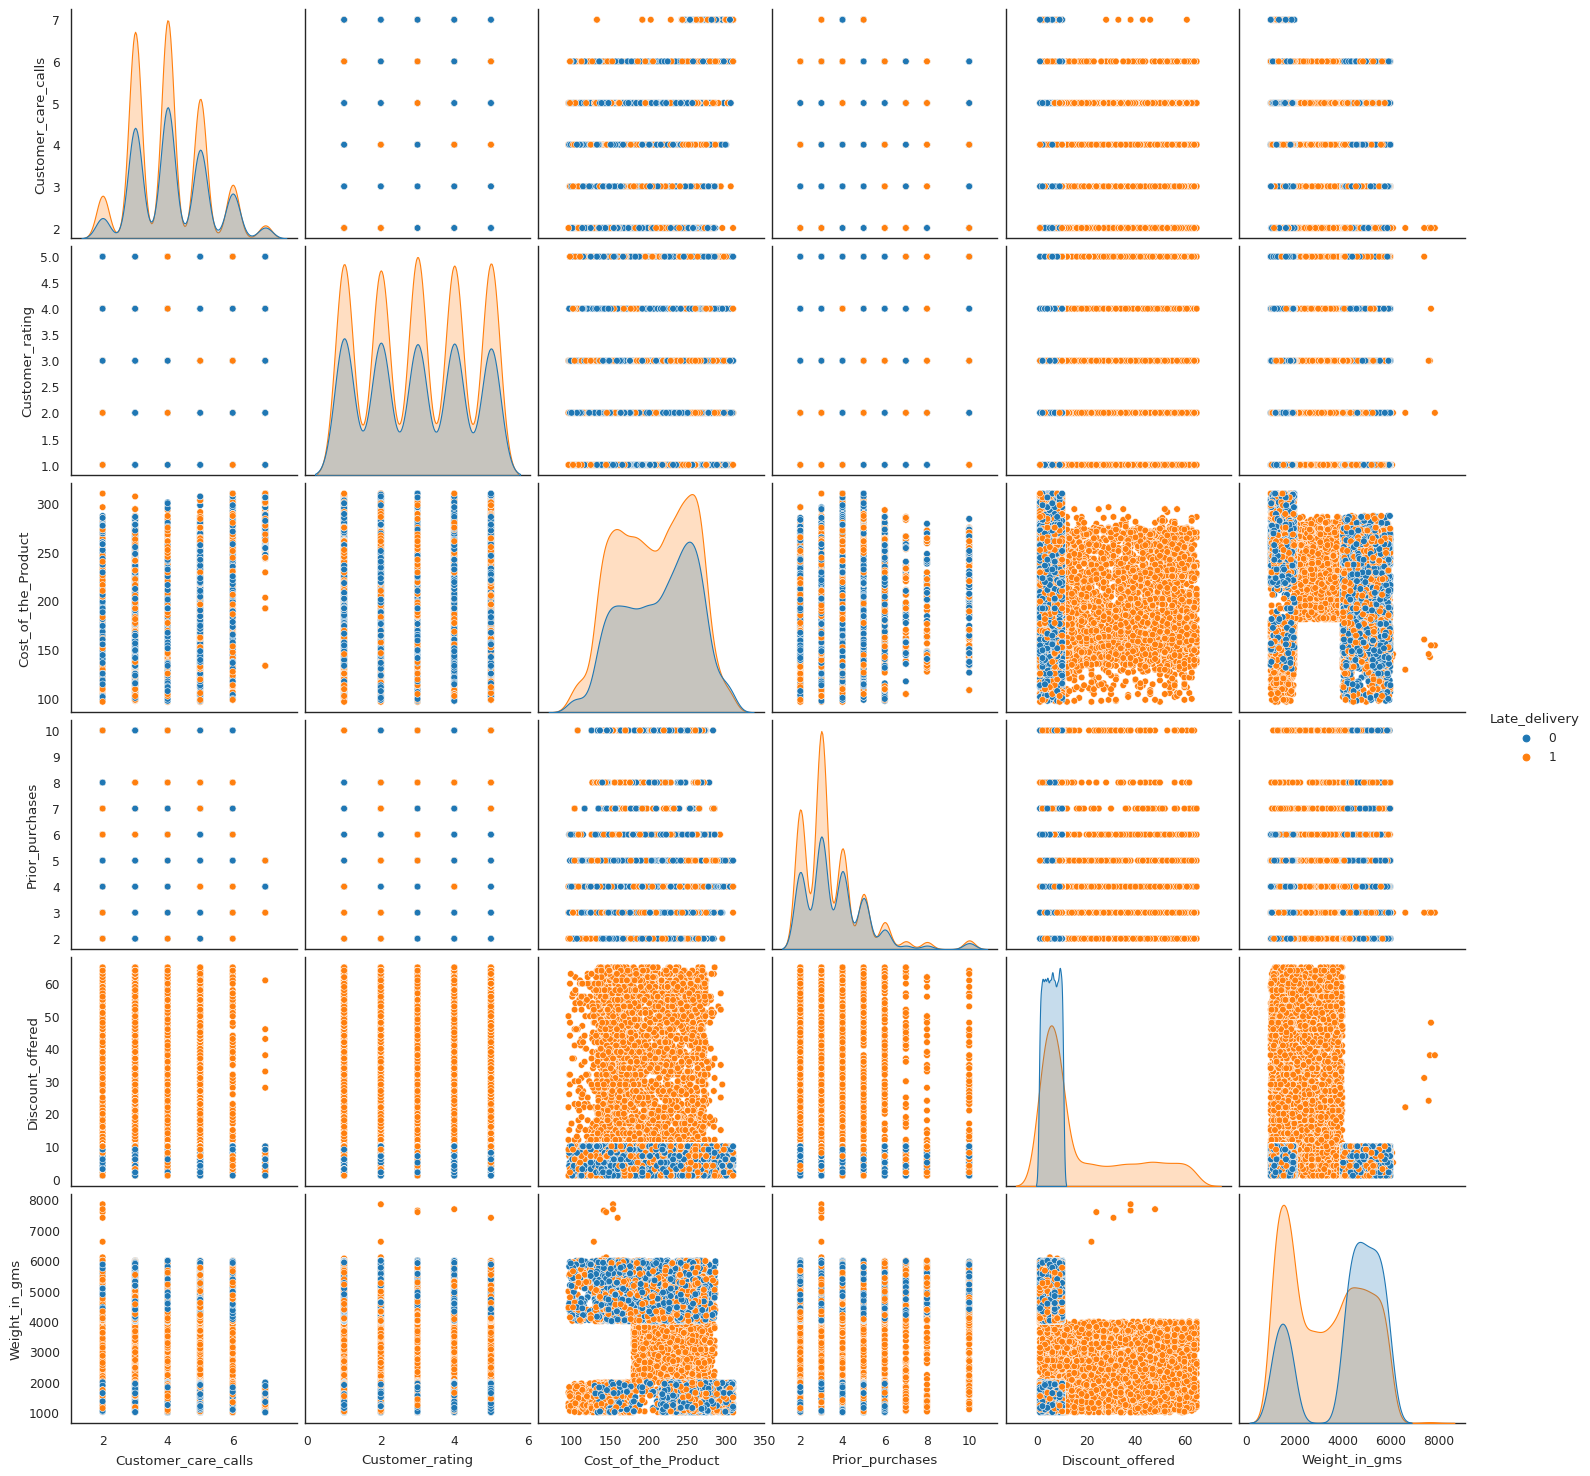

In [ ]:
# ONLY UNCOMMENT AND RUN THIS CELL IF NECESSARY TO SHOW PAIR PLOT. CELL TAKES A LONG TIME TO EXECUTE

# create pairplot for all numerical features
sns.pairplot(df, hue='Late_delivery')
plt.show()

Terdapat segmentasi data yang secara visual cukup jelas terlihat pada beberapa pair plot. Secara visual, dapat diambil beberapa insight sebagai berikut:
- Pada `Discount_offered` terhadap `Weight_in_gms`, pada umumnya barang-barang yang beratnya di atas 4000 gram tidak diberikan diskon lebih besar dari 10% (kecuali untuk beberapa outlier).
- Tidak ada barang yang sampai tepat waktu pada barang yang diberikan diskon lebih dari 10%
- Barang dengan berat di antara 2000-4000 gram harganya ada di kisaran ~200 sampai ~300 dollar, dan tidak ada yang tepat waktu
- Terdapat beberapa data outlier jika dilihat berdasarkan berat barang (`Weight_in_gms`), yaitu barang-barang yang beratnya melebihi 6000 gram, dan untuk barang-barang tersebut tidak ada satupun yang dikirimkan tepat waktu

Berdasarkan hasil korelasi antara fitur, terdapat beberapa hal yang perlu dilakukan, yaitu:
- Beberapa data outlier pada berat barang (`Weight_in_gms`) yang perlu diobservasi lebih lanjut untuk memastikan apakah data tersebut valid atau tidak. Jika data tersebut valid, maka dapat dipertimbangkan untuk menggunakan teknik pre-processing seperti pengurangan dimensi (PCA) atau penanganan outlier untuk memperbaiki performa model.


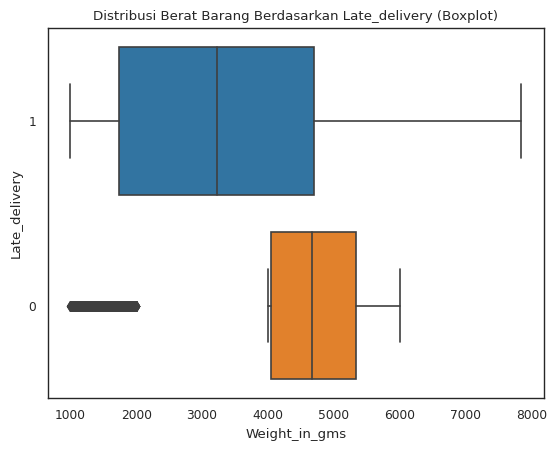

In [ ]:
# check distribution of item weight based on 'reached on time'
sns.boxplot(data=df.astype({'Late_delivery':'string'}), x="Weight_in_gms", y="Late_delivery").set(title="Distribusi Berat Barang Berdasarkan Late_delivery (Boxplot)")

plt.minorticks_on()
plt.show()

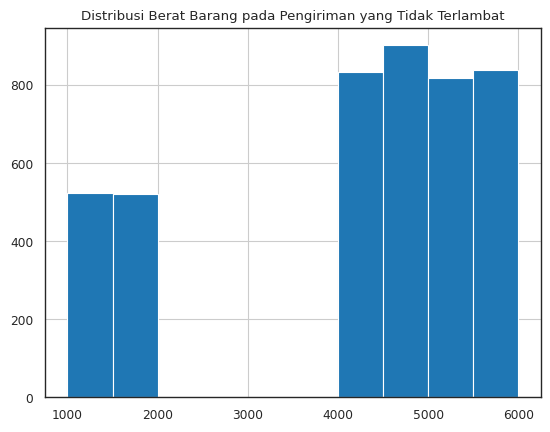

In [ ]:
# create weight histplot for late deliveries
df[df['Late_delivery'] == 0].hist(column = "Weight_in_gms")

plt.title('Distribusi Berat Barang pada Pengiriman yang Tidak Terlambat')
plt.show()

Berdasarkan data yang dimiliki, barang yang dikirim tepat waktu hanya terjadi pada barang yang memiliki berat di antara 1000-2000 gram atau 4000-6000 gram. Untuk barang yang memiliki berat di antara 2000-4000 gram atau di atas 6000 gram dapat dipastikan akan mengalami keterlambatan. Berdasarkan kategori rentang berat ini, tidak ada satupun data yang menyimpang dari rumusan tersebut (tidak ada satupun barang tidak terlambat yang beratnya di 2000-4000 atau diatas 6000 gram).

Pemeriksaan lebih lanjut dapat dilakukan terhadap barang yang berada pada rentang-rentang tersebut untuk dapat meneliti lebih lanjut pengaruh berat barang terhadap keterlambatan pengiriman.

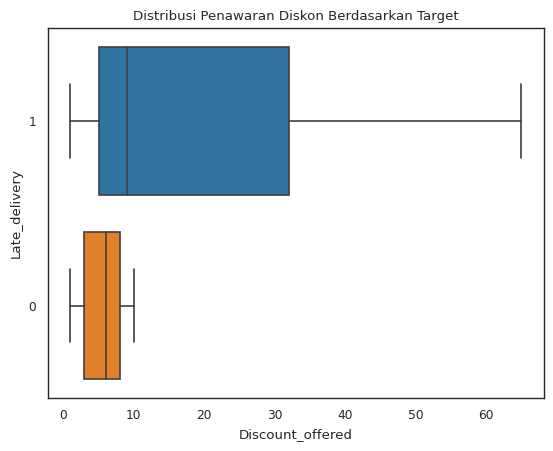

In [ ]:
sns.boxplot(data=df.astype({'Late_delivery':'string'}), x="Discount_offered", y='Late_delivery')

plt.title('Distribusi Penawaran Diskon Berdasarkan Target')
plt.show()

Berdasarkan data yang dimiliki, Ketepatan waktu pengiriman hanya terjadi pada barang yang diberikan diskon 0 sampai 10 persen, sedangkan pada barang yang diberikan diskon diatas 10 persen tidak ada satupun yang tidak terlambat. Sebuah kategori dapat dibentuk untuk memisahkan barang berdasarkan jumlah diskon yang ditawarkan: apakah suatu barang diberikan diskon di bawah 10 persen atau tidak.

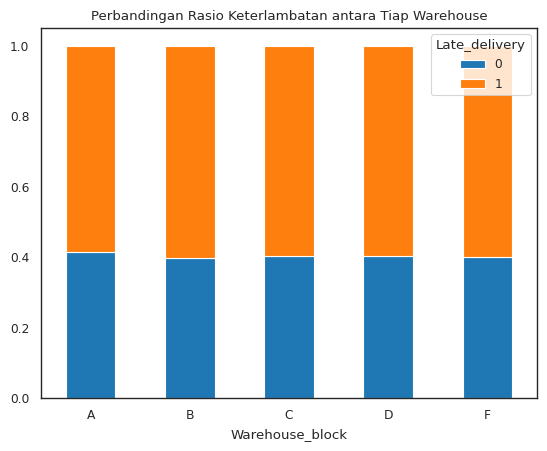

In [ ]:
ct = pd.crosstab(index=df['Warehouse_block'],columns=df['Late_delivery'], normalize='index')

ct.plot(kind='bar', rot=0, stacked=True)

plt.title('Perbandingan Rasio Keterlambatan antara Tiap Warehouse')
plt.show()

Berdasarkan grafik di atas, dapat disimpulkan bahwa tidak ada perbedaan signifikan antara rasio keterlambatan barang pada tiap Warehouse.

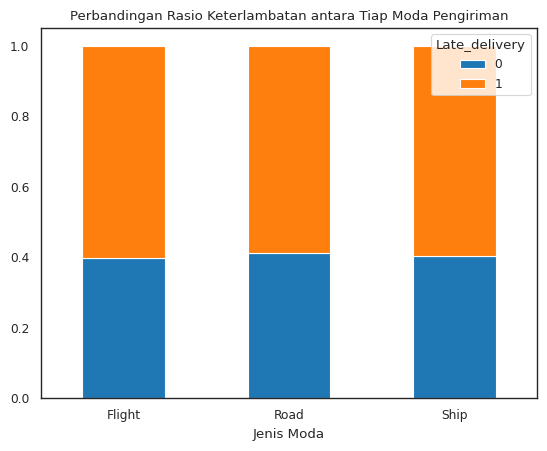

In [ ]:
ct = pd.crosstab(index=df['Mode_of_Shipment'],columns=df['Late_delivery'], normalize='index')

ct.plot(kind='bar', rot=0, stacked=True)

plt.title('Perbandingan Rasio Keterlambatan antara Tiap Moda Pengiriman')
plt.xlabel('Jenis Moda')
plt.show()

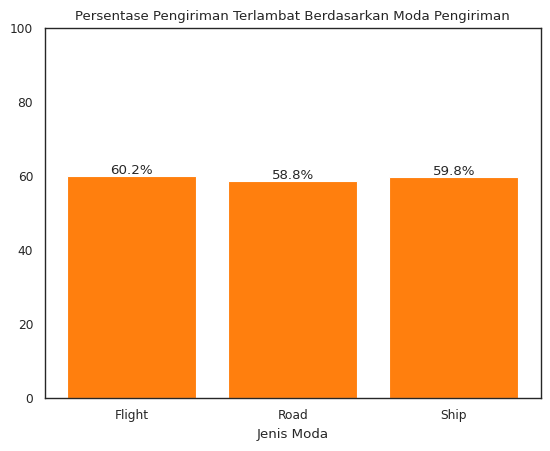

In [ ]:
# Calculate late delivery percentage for each mode of transport
delay_by_shipment = df.groupby('Mode_of_Shipment')['Late_delivery'].mean() * 100

# Membuat bar plot
plt.bar(delay_by_shipment.index, delay_by_shipment.values, color='tab:orange')

# Menambahkan label untuk setiap bar
for i, v in enumerate(delay_by_shipment.values):
    plt.text(i, v+0.5, str(round(v,1)) + '%', ha='center')

# Menambahkan label pada sumbu x dan y, serta judul grafik
plt.title('Persentase Pengiriman Terlambat Berdasarkan Moda Pengiriman')
plt.xlabel('Jenis Moda')
plt.ylim(0, 100)

# Menampilkan grafik
plt.show()

Berdasarkan dua grafik di atas terkait moda pengiriman barang, dapat disimpulkan bahwa rata-rata persentase atau rasio barang yang pengirimannya terlambat dan tepat waktu untuk setiap moda transportasi tidak jauh berbeda.

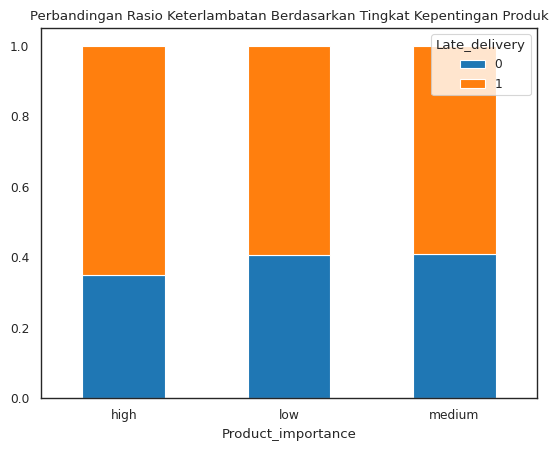

In [ ]:
ct = pd.crosstab(index=df['Product_importance'],columns=df['Late_delivery'], normalize='index')

ct.plot(kind='bar', rot=0, stacked=True)

plt.title('Perbandingan Rasio Keterlambatan Berdasarkan Tingkat Kepentingan Produk')
plt.show()

Berdasarkan grafik di atas, dapat dilihat bahwa untuk barang yang tingkat kepentingannya tinggi (high) relatif lebih sering terlambat dibandingkan yang tingkat kepentingannya rendah (low) maupun sedang (medium), namun dengan besar pengaruh yang tidak terlalu masif.

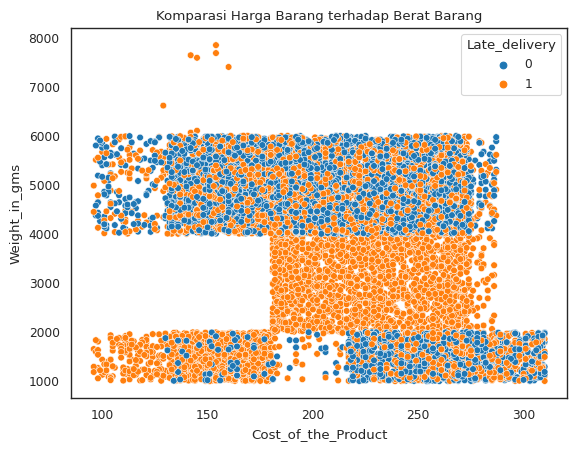

In [ ]:
sns.scatterplot(data=df, x='Cost_of_the_Product', y='Weight_in_gms', hue='Late_delivery')

plt.title('Komparasi Harga Barang terhadap Berat Barang')
plt.show()

Berdasarkan perbandingan harga terhadap berat barang, dapat terlihat segmentasi yang cukup jelas terhadap barang-barang pada rentang berat tertentu. Adapun secara manual sudah terlihat cukup jelas bahwa untuk barang pada rentang berat di atas 6000 gram, harga barang berada di sekitar 100-200 dan tidak ada yang pengirimannya tepat waktu. 

#### Kategorisasi Berat Barang
Adapun untuk melihat hubungan antara berat barang dengan  menambahkan fitur kategori berdasarkan berat barang, dengan rentang sebagai berikut:
1. Berat barang 2000 gram atau lebih ringan, kategori 'light' atau ringan
2. Berat barang di antara 2000 - 4000 gram, kategori 'medium' atau sedang
3. Berat barang di antara 4000 - 6000 gram (inklusif), kategori 'heavy' atau berat
4. Berat barang di atas 6000 gram, kategori 'very heavy' atau sangat berat

In [ ]:
# categorize weight
cond = [
    (df['Weight_in_gms'] <= 2000),
    (df['Weight_in_gms'] > 2000) & (df['Weight_in_gms'] < 4000),
    (df['Weight_in_gms'] >= 4000) & (df['Weight_in_gms'] <= 6000),
    (df['Weight_in_gms'] > 6000),
]

val = ['light', 'medium', 'heavy', 'very heavy']

df['Weight_cat'] = np.select(cond, val)
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Late_delivery,Weight_cat
0,D,Flight,4,2,177,3,low,F,44,1233,1,light
1,F,Flight,4,5,216,2,low,M,59,3088,1,medium
2,A,Flight,2,2,183,4,low,M,48,3374,1,medium
3,B,Flight,3,3,176,4,medium,M,10,1177,1,light
4,C,Flight,2,2,184,3,medium,F,46,2484,1,medium


In [ ]:
df[df['Weight_cat'] == 'light'].describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Late_delivery
count,3245.000000,3245.000000,3245.000000,3245.000000,3245.000000,3245.000000,3245.000000
mean,4.626810,2.982435,214.697072,4.043143,16.922034,1494.070262,0.677658
std,1.334022,1.415738,58.632361,1.269722,18.471671,289.271956,0.467445
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,4.000000,2.000000,158.000000,3.000000,4.000000,1240.000000,0.000000
50%,5.000000,3.000000,232.000000,4.000000,8.000000,1498.000000,1.000000
75%,6.000000,4.000000,264.000000,5.000000,26.000000,1744.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,2000.000000,1.000000


In [ ]:
df[df['Weight_cat'] == 'medium'].describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Late_delivery
count,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.0
mean,3.810190,3.003919,227.235162,3.298992,33.055991,3000.471445,1.0
std,0.943993,1.420335,28.710330,1.555390,18.751335,583.497470,0.0
min,2.000000,1.000000,181.000000,2.000000,1.000000,2003.000000,1.0
25%,3.000000,2.000000,202.000000,2.000000,17.000000,2493.000000,1.0
50%,4.000000,3.000000,226.500000,3.000000,34.000000,2994.000000,1.0
75%,4.000000,4.000000,252.000000,4.000000,49.000000,3516.000000,1.0
max,6.000000,5.000000,286.000000,10.000000,65.000000,3997.000000,1.0


In [ ]:
df[df['Weight_cat'] == 'heavy'].describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Late_delivery
count,5960.000000,5960.000000,5960.00000,5960.000000,5960.000000,5960.000000,5960.000000
mean,3.818792,2.991275,202.72651,3.389933,5.524832,4984.313926,0.431208
std,0.954784,1.410860,44.56119,1.581473,2.922111,577.855397,0.495287
min,2.000000,1.000000,96.00000,2.000000,1.000000,4000.000000,0.000000
25%,3.000000,2.000000,166.00000,2.000000,3.000000,4486.000000,0.000000
50%,4.000000,3.000000,203.00000,3.000000,6.000000,4966.500000,0.000000
75%,4.000000,4.000000,241.25000,4.000000,8.000000,5487.000000,1.000000
max,6.000000,5.000000,287.00000,10.000000,47.000000,6000.000000,1.000000


In [ ]:
df[df['Weight_cat'] == 'very heavy'].describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Late_delivery
count,8.0,8.00000,8.000000,8.0,8.0000,8.00000,8.0
mean,2.0,2.75000,146.375000,3.0,26.7500,7117.37500,1.0
std,0.0,1.28174,9.605616,0.0,15.0119,738.82125,0.0
min,2.0,1.00000,129.000000,3.0,5.0000,6064.00000,1.0
25%,2.0,2.00000,142.000000,3.0,18.5000,6486.00000,1.0
50%,2.0,2.50000,145.000000,3.0,27.5000,7494.50000,1.0
75%,2.0,3.25000,154.000000,3.0,38.0000,7651.00000,1.0
max,2.0,5.00000,160.000000,3.0,48.0000,7846.00000,1.0


Dengan pembagian kategori berat seperti di atas, dapat dilihat bahwa untuk kategori berat 'light' dan 'heavy', tidak ada satupun barang yang pengirimannya tepat waktu, yang dinilai dari nilai rata-rata targetnya yaitu persis di 1.

Untuk rentang harga barang berdasarkan kategori berat adalah sebagai berikut:
1. Kategori berat 'light', harga ada di rentang 96 - 310 atau sama dengan rentang secara keseluruhan (dapat dilihat pada Descriptive Statistic Analysis di poin 1.1)
2. Kategori berat 'medium', harga ada di rentang 181 - 286
3. Kategori berat 'heavy', harga ada di rentang 96 - 287
4. Kategori berat 'very heavy', harga ada di rentang 129 - 160

#### Kategorisasi Harga Barang
Berdasarkan temuan tersebut, harga barang mungkin dapat dikategorisasi juga menjadi:
1. Kategori 'low', dengan harga di bawah 181
2. Kategori 'medium', dengan harga di antara 181 - 287 (inklusif)
3. Kategori 'high', dengan harga di atas 287

In [ ]:
# categorize cost
cond = [
    (df['Cost_of_the_Product'] < 181),
    (df['Cost_of_the_Product'] >= 181) & (df['Cost_of_the_Product'] <= 287),
    (df['Cost_of_the_Product'] > 287)
]

val = ['low', 'medium', 'high']

df['Cost_cat'] = np.select(cond, val)
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Late_delivery,Weight_cat,Cost_cat
0,D,Flight,4,2,177,3,low,F,44,1233,1,light,low
1,F,Flight,4,5,216,2,low,M,59,3088,1,medium,medium
2,A,Flight,2,2,183,4,low,M,48,3374,1,medium,medium
3,B,Flight,3,3,176,4,medium,M,10,1177,1,light,low
4,C,Flight,2,2,184,3,medium,F,46,2484,1,medium,medium


#### Kategorisasi Barang Berdasarkan Diskon yang Ditawarkan
Berdasarkan temuan pada tahap univariate maupun multivariate analysis, barang dapat dikategorisasi lebih lanjut berdasarkan besar diskon yang ditawarkan. Adapun dua kategori besar yang dapat dibuat adalah:
1. Barang yang diberikan diskon lebih kecil atau sama dengan 10%
2. Barang yang diberikan diskon di atas 10%

In [ ]:
# categorize discount
df['Disc_above_10'] = np.where(df['Discount_offered'] > 10, 1, 0)
df.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Late_delivery,Weight_cat,Cost_cat,Disc_above_10
0,D,Flight,4,2,177,3,low,F,44,1233,1,light,low,1
1,F,Flight,4,5,216,2,low,M,59,3088,1,medium,medium,1
2,A,Flight,2,2,183,4,low,M,48,3374,1,medium,medium,1
3,B,Flight,3,3,176,4,medium,M,10,1177,1,light,low,0
4,C,Flight,2,2,184,3,medium,F,46,2484,1,medium,medium,1


In [ ]:
df[df['Disc_above_10'] == 1].describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Late_delivery,Disc_above_10
count,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.0,2647.0
mean,3.747639,2.993578,196.196071,3.295807,38.192293,2366.823196,1.0,1.0
std,0.995345,1.419933,45.536872,1.522492,15.931983,918.202782,0.0,0.0
min,2.000000,1.000000,96.000000,2.000000,11.000000,1001.000000,1.0,1.0
25%,3.000000,2.000000,158.000000,2.000000,24.000000,1577.000000,1.0,1.0
50%,4.000000,3.000000,192.000000,3.000000,39.000000,2239.000000,1.0,1.0
75%,4.000000,4.000000,234.000000,4.000000,52.000000,3129.500000,1.0,1.0
max,7.000000,5.000000,296.000000,10.000000,65.000000,7846.000000,1.0,1.0


Seperti yang dapat dilihat bahwa untuk kategori diskon di atas 10 persen (`Disc_above_10` = 1), tidak ada satupun barang yang pengirimannya tepat waktu (mean untuk target tepat di 1).

Fitur yang dibentuk sudah berbentuk binary sehingga tidak perlu diproses lebih lanjut nantinya.

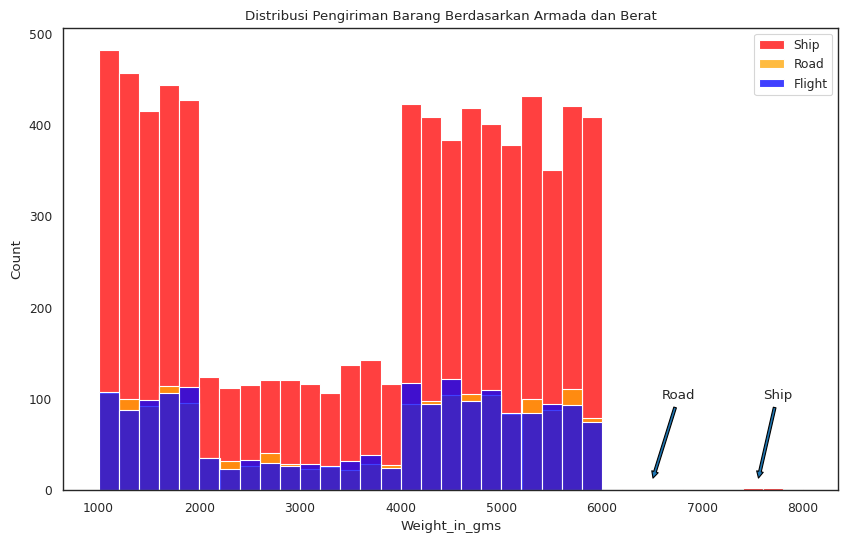

In [ ]:
# Filtering Kolom
flight = df[df['Mode_of_Shipment']=='Flight']
ship = df[df['Mode_of_Shipment']=='Ship']
road = df[df['Mode_of_Shipment']=='Road']

# Visualisasi Distribusi Barang
plt.figure(figsize=(10,6))
sns.histplot(x='Weight_in_gms', binwidth=200, color='red', data=ship, label='Ship')
sns.histplot(x='Weight_in_gms', binwidth=200, color='orange', data=road, label='Road')
sns.histplot(x='Weight_in_gms', binwidth=200, color='blue', data=flight, label='Flight')

# Judul
plt.title('Distribusi Pengiriman Barang Berdasarkan Armada dan Berat')

# Keterangan Tambahan
plt.annotate('Road',
            xy=(6500,10), xytext=(6600, 100), arrowprops=dict(ec='black', arrowstyle='simple',))
plt.annotate('Ship',
            xy=(7550,10), xytext=(7600, 100), arrowprops=dict(ec='black', arrowstyle='simple',))

# Legenda
plt.legend(loc=1)
plt.show()

Terdapat beberapa barang yang memiliki berat di atas 6000 gram, dimana barang yang berada pada rentang 6000-7000 gram hanya dikirimkan melalui jalur darat ('Road'), sedangkan barang yang memiliki berat di atas 7000 gram dikirimkan hanya melalui jalur laut ('Ship').

Barang-barang yang memiliki berat di atas 6000 gram jumlahnya relatif sedikit dan tidak ada satupun yang <b>tidak</b> mengalami keterlambatan.

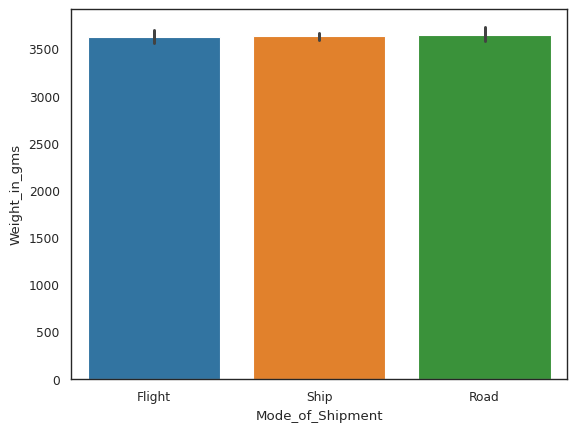

In [ ]:
# average weight per mode of shipment
sns.barplot(x='Mode_of_Shipment', y='Weight_in_gms', estimator='mean', data=df)
plt.show()

Pada analisis univariate, sudah terdeteksi bahwa mayoritas pengiriman dilakukan menggunakan jalur laut (moda 'Ship' atau kapal). Namun pada grafik di atas, jika dilihat berdasarkan rata-rata berat pengiriman barang pada tiap moda maka tiap moda memiliki rata-rata berat yang kurang lebih sama.

### Heatmap Korelasi untuk Fitur Numerik

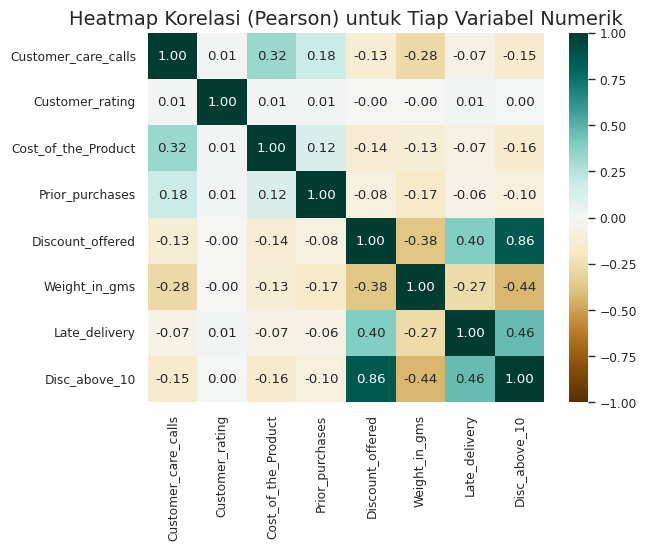

In [ ]:
# correlation heatmap with pearson
fig, ax = plt.subplots()
sns.heatmap(df.corr(method='pearson', numeric_only=True), annot=True, cmap='BrBG', vmin=-1, vmax=1, fmt='.2f')

plt.title('Heatmap Korelasi (Pearson) untuk Tiap Variabel Numerik', fontsize=14)
plt.show()

Berdasarkan hasil heatmap yang dibuat korelasi antar fitur beragam dengan range 1 sampai -1. Semakin mendekati 1 atau -1 maka korelasi semakin kuat, sedangkan semakin mendekati 0 maka korelasi semakin lemah. Beberapa nilai korelasi yang paling relevan adalah sebagai berikut:

- `Discount_offered` dengan `Late_delivery` berkorelasi sedang positif, sedangkan `Weight_in_gms` dengan `Late_delivery` berkorelasi lemah negatif
- `Discount_offered` dengan `Weight_in_gms` berkorelasi sedang negatif (dapat mengakibatkan multikolinearitas pada model linear)
- `Cost_of_the_Product` dengan `Customer_care_calls` berkorelasi sedang positif
`Customer_rating` memiliki korelasi yang sangat kecil terhadap seluruh fitur lainnya, termasuk keterlambatan pengiriman

Berdasarkan hasil korelasi antar fitur & target, terdapat beberapa hal yang mungkin perlu dilakukan, yaitu:

  - `Discount_offered` dan `Weight_in_gms` memiliki korelasi yang cukup signifikan, sehingga perlu dilakukan pengecekan terhadap adanya multikolinearitas antara kedua fitur tersebut. Jika ditemukan adanya multikolinearitas, salah satu fitur dapat dihapus atau digabungkan dengan fitur lain.
  - Korelasi antara `Cost_of_the_Product` dengan `Customer_care_calls` perlu diperhatikan pada saat modelling. Jika terdapat multikolinearitas, fitur yang memiliki korelasi lebih rendah dengan target (`Late_delivery`) dapat dihapus atau digabungkan dengan fitur lain.
  - Fitur yang memiliki korelasi rendah dengan target (`Late_delivery`) namun memiliki korelasi yang tinggi dengan fitur lain juga perlu diperhatikan pada saat modelling. Pada beberapa kasus, fitur tersebut mungkin dapat dihapus atau digabungkan dengan fitur lain untuk menghindari multikolinearitas dan meningkatkan akurasi model.


# 2. Data Pre-Processing

## 2.1 Data Cleansing

Sebelum melakukan pemrosesan lebih lanjut, data dipisah terlebih dahulu menjadi fitur dan target, lalu dipisah lebih lanjut menjadi data train dan test. Data train akan digunakan untuk membentuk model, sedangkan data test akan digunakan untuk menguji model yang dihasilkan. Pada tahapan Data Cleansing, pembersihan data tidak dilakukan pada data test karena tiap entry pada data test dianggap sebagai data yang valid dan memang benar ada (bukan merupakan eror).

In [ ]:
# split data into features & target
target = 'Late_delivery'
features = df.loc[:, df.columns != target].columns
x_data = df[features]
y_data = df[target]

In [ ]:
# split data menjadi 80% data train dan 20% data test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=random_state, stratify=y_data)

# check amount of data on train and test
print('banyaknya data train =', x_train.shape[0])
print('banyaknya data test =', x_test.shape[0])

# check if split is balanced based on target value
print('mean value of y on train =', y_train.mean())
print('mean value of y on test =', y_test.mean())

banyaknya data train = 8799
banyaknya data test = 2200
mean value of y on train = 0.5966587112171837
mean value of y on test = 0.5968181818181818


### 2.1.1 Handle missing values, duplicated data, dan outliers

Dari Bagian 1.1 (<i>Descriptive Statistics Analytics</i>), diketahui bahwa data <b>tidak memiliki missing value maupun data duplikat</b>, sehingga tidak perlu ditangani lebih lanjut.

Untuk memeriksa outlier, dua metode yang dapat digunakan adalah berdasarkan z-score dan IQR.

In [ ]:
# memeriksa outlier dari tiap kolom numerik menggunakan z-score test
cats = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Weight_cat', 'Cost_cat', 'Disc_above_10']
nums = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

zscore = pd.DataFrame()
outlier = pd.DataFrame()
filtered_zscore = np.array([True] * len(x_train))

for col in nums:
    zscore = abs(stats.zscore(x_train[col])) # hitung absolute z-scorenya
    outlier[col] = x_train[col][zscore>3]
    filtered_zscore = (zscore < 3) & filtered_zscore 

outlier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151 entries, 7930 to 453
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer_care_calls  0 non-null      float64
 1   Customer_rating      0 non-null      float64
 2   Cost_of_the_Product  0 non-null      float64
 3   Prior_purchases      151 non-null    int64  
 4   Discount_offered     2 non-null      float64
 5   Weight_in_gms        0 non-null      float64
dtypes: float64(5), int64(1)
memory usage: 8.3 KB


In [ ]:
# memeriksa outlier dari tiap kolom numerik menggunakan IQR
cats = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Weight_cat', 'Cost_cat', 'Disc_above_10']
nums = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

outlier_iqr = pd.DataFrame()
filtered_IQR = np.array([True] * len(x_train))

for col in nums:
    Q1 = x_train[col].quantile(0.25)
    Q3 = x_train[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 2) ## changed modifier to 2 to increase min and max range
    high_limit = Q3 + (IQR * 2) ## changed modifier to 2 to increase min and max range
    outlier_iqr[col] = x_train[col][(df[col] < low_limit) | (df[col] > high_limit)]
    filtered_IQR = ((x_train[col] >= low_limit) & (x_train[col] <= high_limit)) & filtered_IQR

outlier_iqr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 2068 to 7661
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer_care_calls  0 non-null      float64
 1   Customer_rating      0 non-null      float64
 2   Cost_of_the_Product  0 non-null      float64
 3   Prior_purchases      362 non-null    int64  
 4   Discount_offered     85 non-null     float64
 5   Weight_in_gms        0 non-null      float64
dtypes: float64(5), int64(1)
memory usage: 19.8 KB


<b>CATATAN: Hapus data y_train pada indeks yang sama dengan yang dihapus pada x_train</b>, supaya jumlah data x_train dan y_train tetap sama

In [ ]:
# drop outlier menggunakan zscore
print(f'jumlah baris data train SEBELUM filter outlier: {len(x_train)}')

# get index of outliers
outlier_id = outlier.index
x_train_outlier_removed = x_train.drop(outlier_id)
y_train_outlier_removed = y_train.drop(outlier_id)

print(f'jumlah baris data train SETELAH filter outlier: {len(x_train_outlier_removed)}')
print(f'Pemeriksaan apakah jumlah baris x_train dan y_train sama: {len(x_train_outlier_removed) == len(y_train_outlier_removed)}')

jumlah baris data train SEBELUM filter outlier: 8799
jumlah baris data train SETELAH filter outlier: 8648
Pemeriksaan apakah jumlah baris x_train dan y_train sama: True


Jika penentuan outlier menggunakan basis z-score, 151 data merupakan data outlier berdasarkan `Prior_purchases` dan `Discount_offered`nya (sekitar 2% dari keseluruhan data train), sedangkan jika menggunakan IQR yang dimodifikasi (konstanta batas atas dan bawah diubah dari 1.5 menjadi 2.0), maka terdapat 362 data yang merupakan outlier (sekitar 4.2% dari data train). 

Karena jumlah outlier tidak terlalu banyak dan data yang tersisa masih cukup banyak, maka data outlier dapat dihapus jika memang dirasa tidak diperlukan.

Dalam tahap ini, dipilih metode <b>z-score</b> untuk menentukan dan menghapus data outlier. Jumlah data train berkurang dari 8799 menjadi 8649.

### 2.1.2 Feature Transformation

Sebelum melakukan transformasi data, ada baiknya untuk melihat kembali distribusi data train setelah dilakukan pemisahan train/test dan penghapusan outlier.

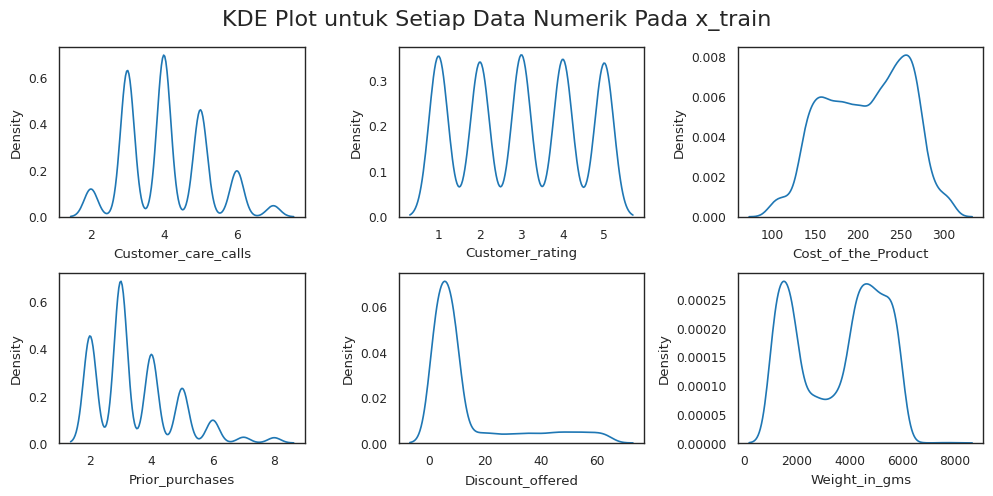

In [ ]:
# Tinjau distribusi dari kolom-kolom numerik pada data menggunakan KDEplot dari data yang telah di smoothing
nums = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
fig.suptitle('KDE Plot untuk Setiap Data Numerik Pada x_train', fontsize=16)

i = 0
for y in axes:
    for ax in y:
        column = nums[i]
        sns.kdeplot(x_train_outlier_removed, x=column, ax=ax)
        ax.minorticks_on()
        i += 1

fig.tight_layout(pad=1)
plt.show()

In [ ]:
# menghitung derajat skewness dari tiap data numerik
skew_score = []                          
for i in nums:
  skew_score.append(round(skew(x_train_outlier_removed[i]),3))

df_skewness = pd.DataFrame({'fitur':nums, 'derajat skewness':skew_score})
df_skewness

,fitur,derajat skewness
0,Customer_care_calls,0.392
1,Customer_rating,0.006
2,Cost_of_the_Product,-0.164
3,Prior_purchases,1.004
4,Discount_offered,1.784
5,Weight_in_gms,-0.235


Setelah meninjau hasil KDEplot dan derajat skewness nya, kolom `Customer_care_calls`, `Customer_rating`, `Cost_of_the_Product`, dan `Weight_in_gms` dapat diasumsikan memiliki distribusi yang normal. Fitur `Prior_purchases` dan `Discount_offered` perlu dinormalisasi untuk meningkatkan performa model terutama pada pembentukan model-model linear/regresi.

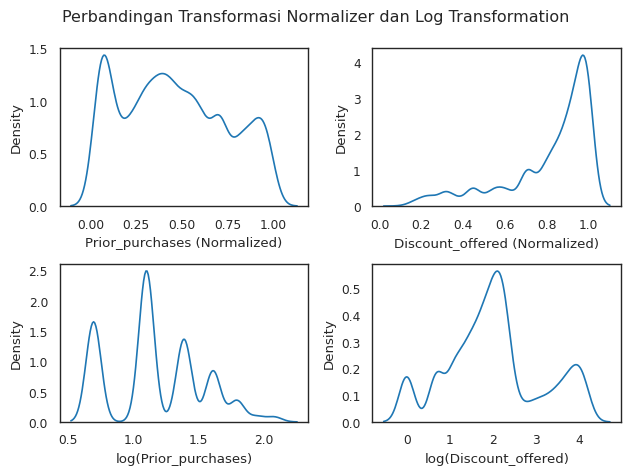

In [ ]:
# Lakukan transformasi untuk menormalkan Prior_purchases dan Discount_offered, gunakan Normalizer dan Log Transformation
col = ['Prior_purchases', 'Discount_offered']

prior_purchases_norm = Normalizer()
x_norm = prior_purchases_norm.fit_transform(x_train_outlier_removed[col].values.reshape(len(x_train_outlier_removed),2))
x_log = np.log(x_train_outlier_removed[col])

plt.subplot(2, 2, 1)
sns.kdeplot(x_norm[:,0])
plt.xlabel('Prior_purchases (Normalized)')

plt.subplot(2, 2, 2) 
sns.kdeplot(x_norm[:,1])
plt.xlabel('Discount_offered (Normalized)')

plt.subplot(2, 2, 3) 
sns.kdeplot(x_log['Prior_purchases'])
plt.xlabel('log(Prior_purchases)')

plt.subplot(2, 2, 4) 
sns.kdeplot(x_log['Discount_offered'])
plt.xlabel('log(Discount_offered)')

plt.suptitle('Perbandingan Transformasi Normalizer dan Log Transformation')
plt.tight_layout()
plt.show()

In [ ]:
# Periksa skewness setelah transformasi
df_skewness = pd.DataFrame({'fitur':col, 
                            'skewness awal': skew(x_train_outlier_removed[col]),
                            'skewness normalizer': skew(x_norm),
                            'skewness log': skew(x_log)})

df_skewness

,fitur,skewness awal,skewness normalizer,skewness log
0,Prior_purchases,1.003699,0.201736,0.221924
1,Discount_offered,1.783852,-1.381430,0.221275


Dari nilai derajat skewness di atas, dapat dipilih transformasi Normalizer untuk `Prior_purchases` dan Log Transformation untuk `Discount_offered`.


Selanjutnya lakukan juga scaling untuk semua data numerik menggunakan MinMaxScaler. 

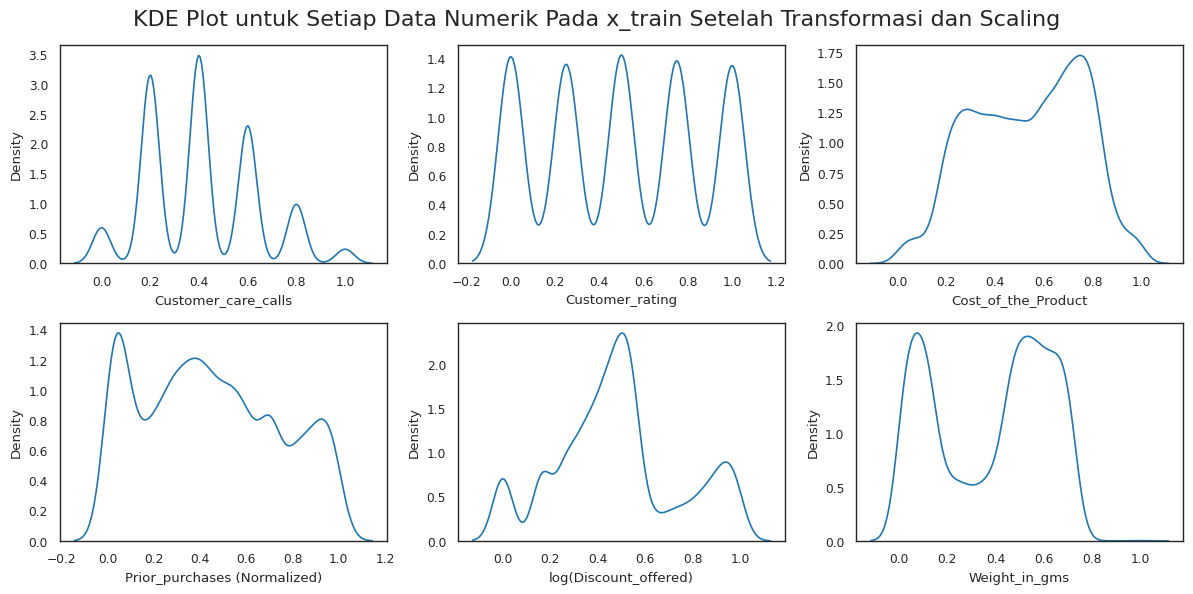

In [ ]:
# buat dataset baru dengan fitur yang sudah dinormalisasi dan standarisasi
x_train_transformed = x_train_outlier_removed.copy()
x_train_transformed['Prior_purchases'] = x_norm[:,0]
x_train_transformed['Discount_offered'] = x_log['Discount_offered']
x_train_transformed[nums] = MinMaxScaler().fit_transform(x_train_transformed[nums].values.reshape(x_train_outlier_removed[nums].shape))

# KDEplot data numerik setelah transformasi + scaling
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

i = 0
for y in axes:
    for ax in y:
        column = nums[i]
        sns.kdeplot(x_train_transformed, x=column, ax=ax)
        ax.minorticks_on()
        i += 1

axes[1,0].set_xlabel('Prior_purchases (Normalized)')
axes[1,1].set_xlabel('log(Discount_offered)')
fig.suptitle('KDE Plot untuk Setiap Data Numerik Pada x_train Setelah Transformasi dan Scaling', fontsize=16)
fig.tight_layout(pad=1)
plt.show()

In [ ]:
# cek deskriptif dan sebaran data setelah transformasi data
x_train_transformed.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Disc_above_10
count,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000,8648.000000
mean,0.412049,0.496473,0.533979,0.445313,0.479833,0.382126,0.242599
std,0.227329,0.352738,0.224823,0.295951,0.260432,0.239062,0.428680
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.250000,0.345794,0.193626,0.332095,0.121987,0.000000
50%,0.400000,0.500000,0.551402,0.433124,0.466155,0.458145,0.000000
75%,0.600000,0.750000,0.724299,0.703417,0.551598,0.588641,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Berdasarkan pemeriksaan plot dan statistik deskriptif, dapat dilihat bahwa standarisasi dan normalisasi sudah berhasil dilakukan, dimana sebaran data tiap fitur berada pada rentang 0 sampai 1.

Transformasi yang sama akan dilakukan pada data test juga sehingga model yang dibentuk dapat diterapkan kepada data test juga.

### 2.1.3 Feature Encoding

Terdapat beberapa fitur kategorikal yang tipe datanya berbentuk object, sehingga sebelum dimasukan ke dalam model, perlu dilakukan encoding menjadi satu kolom atau lebih berbentuk numerik untuk fitur-fitur tersebut supaya model dapat lebih mudah dibentuk.

In [ ]:
# create copy before encoding
x_train_encoded = x_train_transformed.copy()
x_test_encoded = x_test.copy() #harusnya x_test_transformed, tapi belum



# label encoder (for Gender)
gender_encoder = LabelEncoder()
gender_encoder.fit(x_train_encoded['Gender'])

# encode for both train and test, directly replace original feature
x_train_encoded['Gender'] = gender_encoder.transform(x_train_encoded['Gender'])
x_test_encoded['Gender'] = gender_encoder.transform(x_test_encoded['Gender'])



# ordinal encoder (for product importance)
urutan = ['low', 'medium', 'high']
prod_importance_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, categories=[urutan])

# fit and transform encoder to the 'Product_importance' column, transform x_test using the same encoder. directly replace old feature
x_train_encoded['Product_importance'] = prod_importance_encoder.fit_transform(x_train_encoded[['Product_importance']])
x_test_encoded['Product_importance'] = prod_importance_encoder.transform(x_test_encoded[['Product_importance']])



# one hot encoder for warehouse, mode of shipment, weight category, and cost category
ohe_list = ['Warehouse_block', 'Mode_of_Shipment', 'Weight_cat', 'Cost_cat']

# create an encoder and fit the dataframe
ohe_encoder = OneHotEncoder(sparse=False).fit(x_train_encoded[ohe_list])

# transform train data
train_encoded = ohe_encoder.transform(x_train_encoded[ohe_list])
train_encoded_df = pd.DataFrame(train_encoded, columns=ohe_encoder.get_feature_names_out(), index=x_train_encoded.index)

x_train_encoded = pd.concat([x_train_encoded, train_encoded_df], axis=1)

# transform test data
test_encoded = ohe_encoder.transform(x_test_encoded[ohe_list])
test_encoded_df = pd.DataFrame(test_encoded, columns=ohe_encoder.get_feature_names_out(), index=x_test_encoded.index)

x_test_encoded = pd.concat([x_test_encoded, test_encoded_df], axis=1)



# drop unused features after OHE
x_train_encoded.drop(ohe_list, axis=1, inplace=True)
x_test_encoded.drop(ohe_list, axis=1, inplace=True)

In [ ]:
# check if columns are same on x train and test after encoding
print(list(x_train_encoded.columns) == list(x_test_encoded.columns))

True


In [ ]:
# print columns after encoding
for col in x_train_encoded.columns:
    print(col)

Customer_care_calls
Customer_rating
Cost_of_the_Product
Prior_purchases
Product_importance
Gender
Discount_offered
Weight_in_gms
Disc_above_10
Warehouse_block_A
Warehouse_block_B
Warehouse_block_C
Warehouse_block_D
Warehouse_block_F
Mode_of_Shipment_Flight
Mode_of_Shipment_Road
Mode_of_Shipment_Ship
Weight_cat_heavy
Weight_cat_light
Weight_cat_medium
Weight_cat_very heavy
Cost_cat_high
Cost_cat_low
Cost_cat_medium


Setelah melakukan encoding, beberapa kolom kategorikal pada data train diubah menjadi beberapa kolom untuk mempermudah pembentukan model:
1. `Warehouse_block` diubah menjadi 5 kolom menggunakan One-Hot Encoding
2. `Mode_of_Shipment` diubah menjadi 3 kolom menggunakan One-Hot Encoding
3. `Gender` diubah menjadi kolom binary, dimana 0 = Female dan 1 = Male
4. `Product_importance` diubah menjadi kolom ordinal, dimana 0 = low, 1 = medium, dan 2 = high 
5. `Weight_cat` diubah menjadi 4 kolom menggunakan One-Hot Encoding
6. `Cost_cat` diubah menjadi 3 kolom menggunakan One-Hot Encoding

`Disc_above_10` tidak perlu di-encoding karena sudah berbentuk binary.

Pada metode One Hot Encoding, tidak ada fitur yang di drop karena pengurangan satu fitur hanya perlu dilakukan jika model yang dibentuk adalah model linear untuk menghindari multikolinearitas. Penghapusan fitur dapat dilakukan secara manual pada pembentukan model linear, jika ada.

Transformasi yang sama dilakukan pada data test juga sehingga model yang dibentuk dapat diterapkan kepada data test juga.

### 2.1.4 Handle Class Imbalance

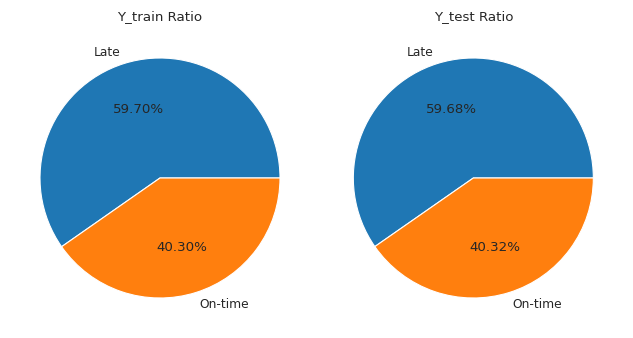

In [66]:
# check ratio on on-time vs late deliveries
plt.subplot(1, 2, 1)
plt.title('Y_train Ratio')
y_train_outlier_removed.value_counts().plot.pie(labels=['Late', 'On-time'], autopct='%.2f%%')
plt.ylabel('')

plt.subplot(1, 2, 2)
plt.title('Y_test Ratio')
y_test.value_counts().plot.pie(labels=['Late', 'On-time'], autopct='%.2f%%')
plt.ylabel('')

# Add a title to the whole plot
fig.suptitle('Ratio of Late vs On-time Deliveries for Train and Test Data', fontsize=16, fontweight='bold', y=1.1)

plt.tight_layout(pad=1)
plt.show()

Pembagian rasio keterlambatan pada data train maupun data test serupa karena sudah dilakukan stratifikasi berdasarkan target pada tahap data splitting, dan penghapusan outlier tidak terlalu berdampak secara signifikan terhadap rasio ini karena jumlah outlier tidak terlalu signifikan dan juga diduga tersebar merata. Rasio yang mendekati 60:40 dinilai masih cukup imbang sehingga tidak perlu dilakukan oversampling untuk menyeimbangkan rasio tersebut.

## 2.2. Feature Engineering

### 2.2.1. Feature Selection

In [ ]:
# copy encoded dataframe and add y_train back for feature heatmap
x_train_hm = x_train_encoded.copy()
x_train_hm[target] = y_train_outlier_removed

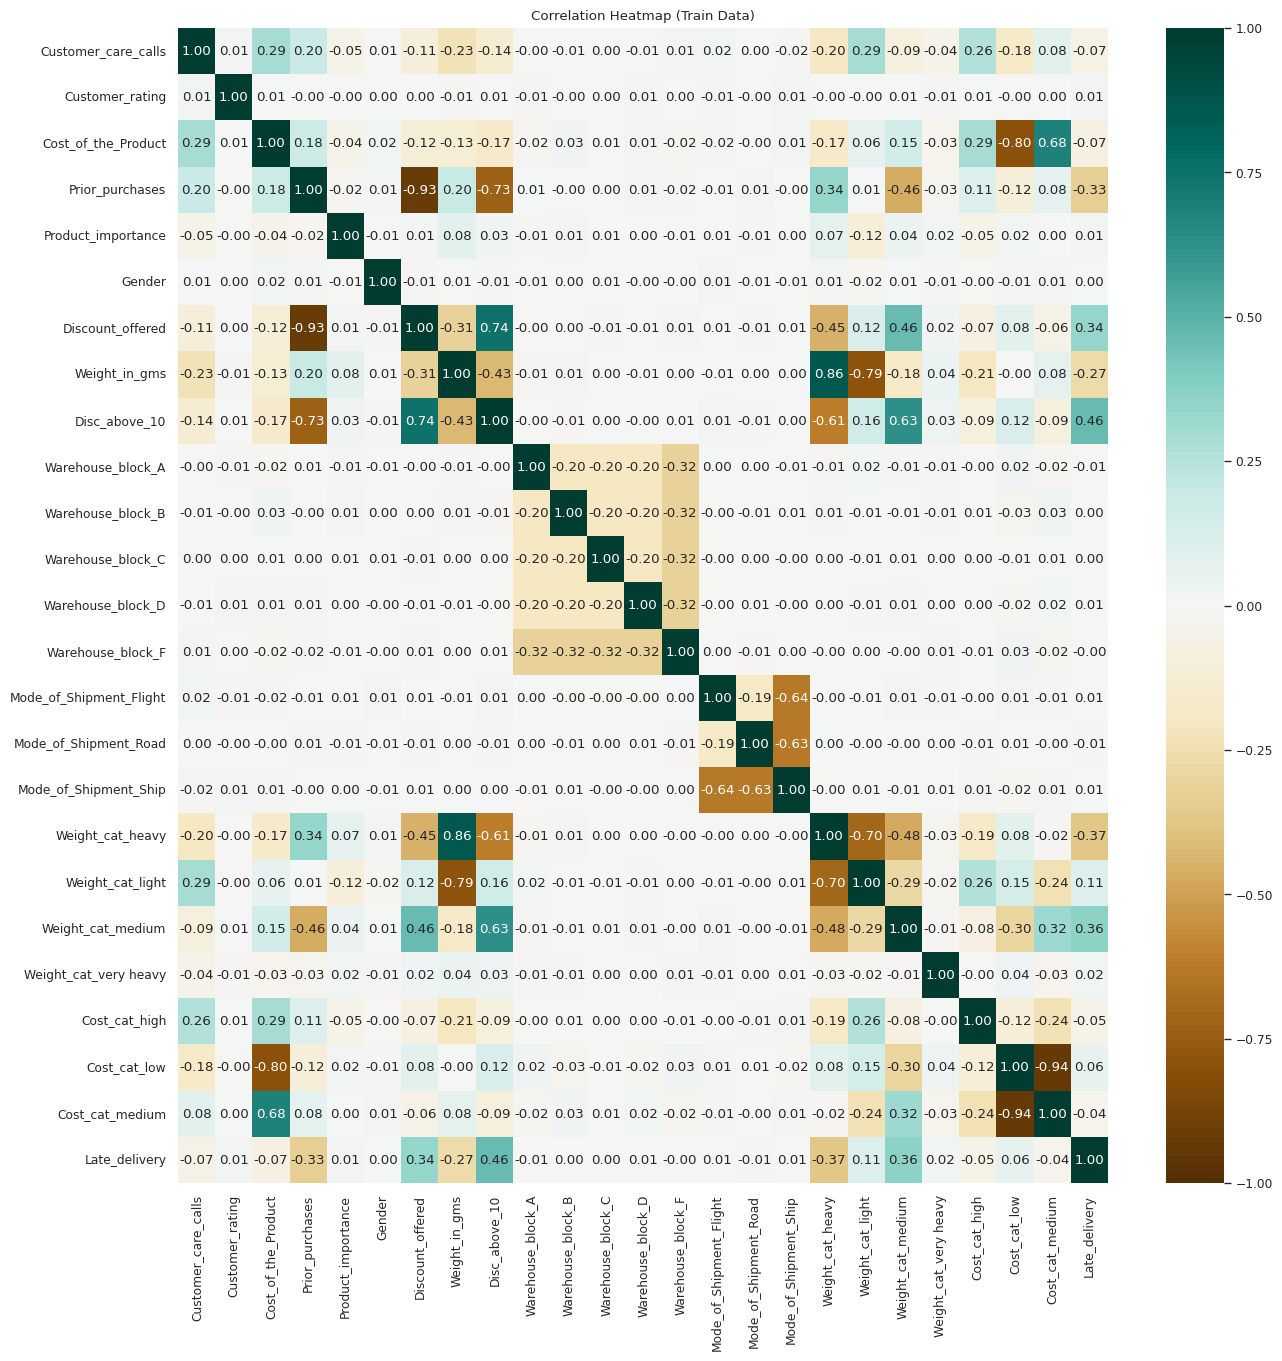

In [ ]:
# buat corr dari df x_train_new
plt.figure(figsize=(15, 15))
sns.heatmap(x_train_hm.corr(method='spearman', numeric_only=True), cmap='BrBG', annot=True, vmin=-1, vmax=1, fmt='.2f')

plt.title('Correlation Heatmap (Train Data)')
plt.show()

Setelah dilakukan pemeriksaan ulang korelasi antar fitur, ditemukan bahwa terdapat enam fitur yang memiliki korelasi yang cukup kuat terhadap target, yaitu:
1. `Prior_purchases`, dengan koefisien -0.33
2. `Discount_offered`, dengan koefisien 0.34
3. `Weight_in_gms`, dengan koefisien -0.27
4. `Disc_above_10`, dengan koefisien 0.46
5. `Weight_cat_heavy`, dengan koefisien -0.37, dan
6. `Weight_cat_medium`, dengan koefisien 0.36

`Customer_rating`, `Warehouse_block`, `Mode_of_shipment`, dan `gender` memiliki korelasi yang sangat rendah terhadap semua fitur (kecuali fitur One-Hot pasangannya), sehingga diduga aman untuk di-drop atau tidak digunakan dalam model karena tidak akan mempengaruhi model secara signifikan.

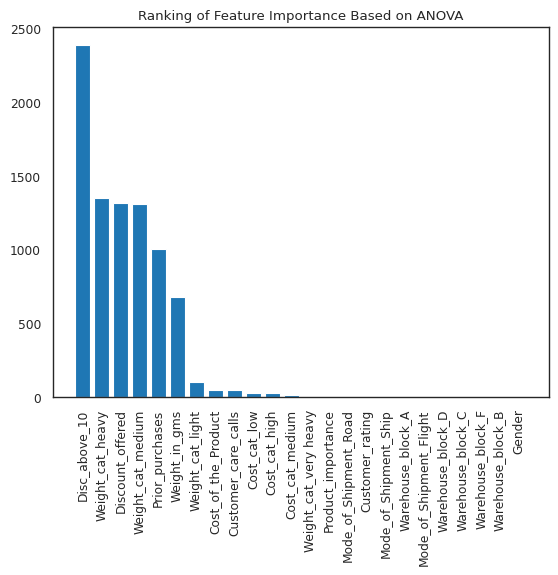

In [ ]:
# using ANOVA
selector = SelectKBest(f_classif, k='all')
kbest_fit = selector.fit_transform(x_train_encoded, y_train_outlier_removed)

columns = x_train_encoded.columns

feature_scores = list(zip(selector.scores_,columns))
sorted_feature_scores = sorted(feature_scores,reverse=True)

num_list = []
col_list = []
for i in range(len(columns)):
   num_list.append((sorted_feature_scores[i])[0])
   col_list.append((sorted_feature_scores[i])[1])

plt.bar(col_list,num_list)
plt.xticks(rotation=90)
plt.title('Ranking of Feature Importance Based on ANOVA')

plt.show()

Berdasarkan nilai ANOVA fitur terhadap target, dapat diambil kesimpulan yang serupa dengan hasil uji korelasi; bahwa terdapat 6 fitur yang memiliki hubungan yang mendominasi terhadap target, dengan satu fitur (`Disc_above_10`) mendominasi fitur lainnya. 

Tanpa memilih terlebih dahulu jumlah fitur yang akan dipilih nantinya saat pembentukan model, secara garis besar pemilihan jumlah fitur dapat dibagi menjadi dua:

1. Menggunakan enam fitur, seperti yang disebutkan pada uji korelasi, yaitu:
    - `Disc_above_10`
    - `Weight_cat_heavy`
    - `Discount_offered`
    - `Weight_cat_medium`
    - `Prior_purchases`, dan
    - `Weight_in_gms`
2. Menggunakan dua belas fitur, dengan menyertakan enam fitur di atas ditambah empat fitur yang masih memiliki sedikit pengaruh/korelasi dengan target seperti yang terlihat pada grafik di atas, yaitu:
    - `Weight_cat_light`
    - `Cost_of_the_Product`
    - `Customer_care_calls`
    - `Cost_cat_low`
    - `Cost_cat_high`
    - `Cost_cat_medium`

Perlu diingat bahwa untuk model linear, fitur yang memiliki multikolinearitas tinggi perlu ditangani terlebih dahulu.

### 2.2.2. Feature Extraction

Berdasarkan temuan pada bagian Feature Selection, terdapat beberapa fitur yang memiliki korelasi cukup kuat dengan fitur lainnya dan dapat digabung menjadi satu fitur baru, atau salah satu fitur dapat di drop, jika model yang akan dibentuk adalah model linear untuk menghindari multikolinearitas. Namun langkah ini dapat dilewati jika model yang dibentuk merupakan model non-linear, sehingga bersifat opsional.

Mengacu pada bagian 1.3 (Multivariate Analysis), beberapa fitur kategori baru sudah dibentuk berdasarkan `Weight_in_gms`, `Cost_of_the_Product`, dan `Discount_offered`. Adapun beberapa fitur tersebut sudah di proses dengan Feature Encoding pada bagian 2.1.3, kecuali untuk fitur `Disc_above_10` yang sudah merupakan fitur binary.

## 2.3. Preprocessing Pipeline
Sebagai upaya untuk simplifikasi tahapan preprocessing, sebuah pipeline dapat dibentuk dari tiap-tiap langkah yang sudah dilakukan di atas.

Adapun data train yang masuk ke dalam pipeline diasumsikan sudah melewati proses pada 2.1.1 (handling missing values, duplicated data, dan outliers) sehingga proses tersebut tidak perlu dimasukkan sebagai bagian dari pipeline.

Dengan demikian, pipeline akan menggunakan data `x_train_outlier_removed` dan `y_train_outlier_removed`, dan akan menangani proses:
1. Feature Transformation
2. Feature Encoding

Dalam pipeline ini, seluruh fitur akan dimasukkan terlebih dahulu. Setelah model terbentuk, jumlah fitur yang akan digunakan untuk membentuk model berikutnya akan dipertimbangkan ulang.

In [ ]:
## Feature Transformation
# for Discount_offered, use log transformation and MinMaxScaler
dsc_transformer = Pipeline(
    steps=[
        ('logtransformer', FunctionTransformer(np.log)),
        ('scaler', MinMaxScaler()),
    ]
)

# for Prior_purchases, use Normalizer and MinMaxScaler
pp_transformer = Pipeline(
    steps=[
        ('normalizer', Normalizer()), 
        ('scaler', MinMaxScaler())
    ]
)

# for all other numerical features, apply MinMaxScaler
other_nums = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Weight_in_gms']
other_nums_transformer = Pipeline(
    steps=[
        ('scaler', MinMaxScaler()),
    ]
)

## Feature Encoding
# for Gender, use LabelEncoder
gender_transformer = Pipeline(
    steps=[
        ('encoder', LabelEncoder()),
    ]
)

# for Product_importance, use OrdinalEncoder
urutan = ['low', 'medium', 'high']
pi_transformer = Pipeline(
    steps=[
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, categories=[urutan])),
    ]
)

# use OneHotEncoder for Warehouse_block, Mode_of_shipment, Weight_cat, and Cost_cat
# for Gender, since LabelEncoder cannot be used in column transformer, also use OneHotEncoder, but add the parameter drop='if_binary'
ohe_list = ['Gender', 'Warehouse_block', 'Mode_of_Shipment', 'Weight_cat', 'Cost_cat']
ohe_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary')),
    ]
)

# finalize column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('da10', 'passthrough', ['Disc_above_10']),
        ('pp', pp_transformer, ['Prior_purchases']),
        ('dsc', dsc_transformer, ['Discount_offered']),
        ('othernums', other_nums_transformer, other_nums),
        ('pi', pi_transformer, ['Product_importance']),
        ('ohe', ohe_transformer, ohe_list),
    ]
)

In [ ]:
# show preprocessor pipeline
preprocessor

ColumnTransformer(transformers=[('da10', 'passthrough', ['Disc_above_10']),
                                ('pp',
                                 Pipeline(steps=[('normalizer', Normalizer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Prior_purchases']),
                                ('dsc',
                                 Pipeline(steps=[('logtransformer',
                                                  FunctionTransformer(func=<ufunc 'log'>)),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Discount_offered']),
                                ('othernums',
                                 Pipeline(steps=[('scaler', MinMaxSc...
                                  'Cost_of_the_Product', 'Weight_in_gms']),
                                ('pi',
                                 Pipeline(steps=[('encoder',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Product_importance']),
                                ('ohe',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['Gender', 'Warehouse_block',
                                  'Mode_of_Shipment', 'Weight_cat',
                                  'Cost_cat'])])

# 3. Machine Learning Modelling & Evaluation

## 3.1 Modeling

### 3.1.1 Split Data Train & Test

Data harus dipecah menjadi data train dan data test untuk mencegah terjadinya data leakage. Data train akan digunakan untuk memproses data dan membangun model, sedangkan data test akan digunakan untuk mengevaluasi performa model. 

Berikut adalah langkah-langkah yang diambil pada train-test split (2.1 Data Cleansing):
1. Lakukan split antara target dengan fitur terlebih dahulu (`x_data`, `y_data`)
2. Split dengan rasio 80:20, menggunakan parameter random state = 25 (untuk memastikan split data sama tiap kali cell dijalankan) dan `stratify = y_data` (untuk memastikan pembagian dilakukan secara merata berdasarkan target)
3. Pastikan train & test sudah terbagi dengan tepat. 

Hasil akhir yang diperoleh adalah data yang terbagi menjadi **8799 data train dan 2200 data test**.

### 3.1.2 Modeling

Membuat model dengan beberapa algoritma yang sesuai dengan objektif yang ingin
dicapai. Berikut adalah jenis algoritma supervised learning dalam machine learning yang kami gunakan:
1. **Decision Tree**

  Decision tree merupakan algoritma machine learning yang menyajikan algoritma dengan pernyataan bersyarat, yang meliputi cabang untuk mewakili langkah-langkah pengambilan keputusan yang dapat mengarah pada hasil yang menguntungkan.

2. **Random Forest**

  Random Forest merupakan algoritma machine learning yang membangun beberapa decision tree dan menggabungkannya untuk mendapatkan prediksi yang lebih akurat dan stabil.

3. **Logistic Regression**

  Logistic Regression adalah sebuah algoritma klasifikasi untuk mencari hubungan antara fitur (input) diskrit/kontinu dengan probabilitas hasil output diskrit tertentu.

4. **K-Nearest Neighbor**

  KNN merupakan algoritma klasifikasi yang paling sederhana dalam mengklasifikasikan sebuah gambar kedalam sebuah label. Metode ini mengklasifikasikan berdasarkan jarak terdekat dengan objek lain (tetangga).

5. **XG Boost**

  XGBoost (Extreme Gradient Boosting) adalah algoritma boosting tree yang digunakan untuk tugas-tugas klasifikasi dan regresi. Algoritma ini menggabungkan beberapa pohon keputusan sederhana untuk membuat model yang lebih kompleks dan akurat.

### 3.1.3 Model Evaluation: Pemilihan dan perhitungan metrics model


Melakukan evaluasi model untuk mengetahui seberapa baik model tersebut dalam memprediksi data yang belum dilihat sebelumnya. Evaluasi model dilakukan dengan menggunakan metrics atau ukuran performa yang telah ditentukan:

1. **Accuracy**

  Metrics Akurasi biasa digunakan ketika masing-masing label mempunyai kepentingan yang sama dan jumlah labelnya seimbang. 

2. **Precision**

  Metrics Precision biasa digunakan ketika kita lebih memperhatikan jumlah False Positive (FP) yang sebaiknya lebih sedikit dengan label yang seimbang. 

3. **Recall**

  Metrics Recall digunakan jika kita tidak memperbolehkan nilai False Negative yang besar dan labelnya seimbang.

Dari ketiga ukuran performa, dipilih **Recall** sebagai ukuran performa pada kasus ini. Metrik recall cocok digunakan untuk meminimalisir terjadinya kasus False Negative, dimana dalam kasus ini False Negative merupakan kejadian yang diprediksi sebagai Negative (0, atau tidak terlambat) walaupun data aslinya menunjukkan bahwa pengiriman terlambat (1).


### 3.1.4 Model Evaluation: Validasi dengan Cross-Validation


Melakukan cross-validation dengan menggunakan 10 fold untuk masing-masing model. Tujuannya adalah untuk membandingkan score accuracy dari data training dan score hasil cross validation antar model.

In [ ]:
models = [
    ['Decision Tree', DecisionTreeClassifier(random_state=random_state)],
    ['Random Forest', RandomForestClassifier(random_state=random_state)],
    ['Logistic Regression', LogisticRegression(random_state=random_state)],
    ['KNN', KNeighborsClassifier()],
    ['XGBoost', XGBClassifier()]
]

In [ ]:
def cross_validation(model):
    model_name = []

    cv_accuracy_mean = []
    cv_accuracy_std = []
    training_accuracy = []

    cv_precision_mean = []
    cv_precision_std = []
    training_precision = []

    cv_recall_mean = []
    cv_recall_std = []
    training_recall = []
    for name, model in models:
    
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ]) 
        model_name.append(name)

        #scoring
        scoring= ['accuracy', 'precision', 'recall']

        # test
        cv_score = cross_validate(pipeline, x_train_outlier_removed, y_train_outlier_removed, scoring=scoring, cv=5, n_jobs=-1)

        cv_accuracy_mean.append(cv_score['test_accuracy'].mean())
        cv_accuracy_std.append(cv_score['test_accuracy'].std())

        cv_precision_mean.append(abs(cv_score['test_precision']).mean())
        cv_precision_std.append(abs(cv_score['test_precision']).std())

        cv_recall_mean.append(abs(cv_score['test_recall']).mean())
        cv_recall_std.append(abs(cv_score['test_recall']).std())

        # training
        pipeline.fit(x_train_outlier_removed, y_train_outlier_removed)
        y_pred = pipeline.predict(x_train_outlier_removed)
        training_accuracy.append(accuracy_score(y_train_outlier_removed, y_pred))
        training_precision.append(precision_score(y_train_outlier_removed, y_pred))
        training_recall.append(recall_score(y_train_outlier_removed, y_pred))
    
    return pd.DataFrame({
        'Model': model_name,
        'Training Accuracy': training_accuracy,
        'CV Accuracy (mean)': cv_accuracy_mean,
        'CV Accuracy (std)' : cv_accuracy_std,
        'Training Precision' : training_precision,
        'CV Precision (mean)': cv_precision_mean,
        'CV Precision (std)': cv_precision_std,
        'Training Recall' : training_recall,
        'CV Recall (mean)' : cv_recall_mean,
        'CV Recall (std)' : cv_recall_std
    })

In [ ]:
cv_result = cross_validation(models)
cv_result

,Model,Training Accuracy,CV Accuracy (mean),CV Accuracy (std),Training Precision,CV Precision (mean),CV Precision (std),Training Recall,CV Recall (mean),CV Recall (std)
0,Decision Tree,1.000000,0.644658,0.002104,1.000000,0.701457,0.003215,1.000000,0.704823,0.004997
1,Random Forest,1.000000,0.653330,0.004914,1.000000,0.751894,0.006149,1.000000,0.625995,0.011590
2,Logistic Regression,0.678885,0.674723,0.011130,0.841052,0.834946,0.021207,0.569824,0.568280,0.024078
3,KNN,0.776827,0.646046,0.008571,0.835861,0.717801,0.009464,0.779198,0.671125,0.009964
4,XGBoost,0.891304,0.654374,0.015885,0.949925,0.736259,0.021928,0.863451,0.657566,0.017276


Dari hasil tersebut, model yang dipilih adalah Logistic Regression karena memiliki rata-rata skor precision cross validation yang paling tinggi secara signifikan jika dibandingkan dengan bentuk model lainnya.

Sebagai pembanding, model kedua terbaik (**Random Forest**) juga akan dibentuk, dengan pertimbangan bahwa model tersebut bisa lebih baik lagi jika dilakukan hyperparameter tuning.

### 3.1.5 Hyperparameter Tuning: Logistic Regression

Pada model Logistic Regression, tidak banyak hyperparameter yang dapat diuji, namun langkah ini tetap penting untuk mengupayakan supaya model yang dihasilkan adalah model yang tidak overfit maupun underfit.

In [ ]:
# fit model into pipeline 
lr = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('classifier', LogisticRegression(random_state=random_state))
    ]
)

# hyperparameter combinations
param_grid = {
    'classifier__penalty' : ['l2'],
    'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'classifier__C' : [10000, 1000, 100, 10, 1.0, 0.1, 0.01]
}

# search best hyperparameter using grid search
gs = GridSearchCV(lr, param_grid, n_jobs=-1, scoring='recall', cv=10)
gs.fit(x_train_outlier_removed, y_train_outlier_removed)

# print the best hyperparameters 
print('Best hyperparameters using bayesian search :', gs.best_params_)

Best hyperparameters using bayesian search : {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}


In [ ]:
# masukkan hasil dari best_params_ ke dalam classifier baru
lr_best = LogisticRegression(random_state=random_state, C=0.01, penalty='l2', solver='newton-cg') 

lr_best_pipe = Pipeline( 
    steps = [ 
        ('preprocessor', preprocessor),
        ('classifier', lr_best)
    ]
)

lr_best_pipe.fit(x_train_outlier_removed, y_train_outlier_removed)

# evaluate model
y_train_pred = lr_best_pipe.predict(x_train)
y_pred = lr_best_pipe.predict(x_test)

# main model evaluation: precision
print('Recall score data TRAIN :', round(recall_score(y_train, y_train_pred)*100, 3), '%')
print('Recall score data TEST  :', round(recall_score(y_test, y_pred)*100, 3), '%')

# other scores
print('\nOther Scores (based on test data):\n')
print('Accuracy score :', round(accuracy_score(y_test, y_pred)*100, 3), '%')
print('F-1 score :', round(f1_score(y_test, y_pred)*100, 3), '%')
print('Precision score :', round(precision_score(y_test, y_pred)*100, 3), '%')
print('Jaccard score :', round(jaccard_score(y_test, y_pred)*100, 3), '%')

# mengukur perbedaan antara probabilitas aktual dan probabilitas prediksi yang dihitung sebagai logaritma basis 2 dari likelihood
print('Log Loss :', (log_loss(y_test, y_pred))) 

Recall score data TRAIN : 63.962 %
Recall score data TEST  : 63.062 %

Other Scores (based on test data):

Accuracy score : 65.455 %
F-1 score : 68.543 %
Precision score : 75.068 %
Jaccard score : 52.141 %
Log Loss : 12.451443898058654


Dari hasil hyperparameter tuning menggunakan Random Forest Classifier, didapatkan hasil bahwa parameter terbaik untuk model ini adalah menggunakan:

    C: 10000
    Penalty: 'l2'
    Solver: 'sag'

Pada dasarnya, untuk model logit tuning hyperparameter tidak akan merubah model secara signifikan. Hasil akhir yang diperoleh berdasarkan kombinasi hyperparameter terbaik di atas adalah model dengan presisi sebesar 85.15% pada data train dan 83.61% pada data test, sehingga model tidak mengalami overfitting maupun underfitting secara signifikan.


### 3.1.6 Hyperparameter Tuning: Random Forest Classfier 

Hyperparameter tuning pada **Random Forest Classifier** sangat penting untuk meningkatkan kinerja model. Dengan hyperparameter tuning pada Random Forest Classifier kita dapat menemukan kombinasi hyperparameter yang optimal dan mampu meningkatkan kinerja model secara signifikan.

In [ ]:
# combine preprocessing and classifier into a single pipeline 
dtc = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('classifier', DecisionTreeClassifier(random_state=random_state))
    ]
)

# hyperparameter combinations
param_grid = {
    'classifier__criterion' : ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth' : [None, 5, 10, 15, 20, 30, 40, 50, 100],
    'classifier__max_features' : ['sqrt', 'log2', None],
}

# iterate with Randomized Search
rs = RandomizedSearchCV(dtc, param_grid, n_iter=100, n_jobs=-1, cv=10, scoring='recall', random_state=random_state)
rs.fit(x_train_outlier_removed, y_train_outlier_removed)

# print the best hyperparameters
print('Best hyperparameters using randomized search:', rs.best_params_)

Best hyperparameters using randomized search: {'classifier__max_features': None, 'classifier__max_depth': None, 'classifier__criterion': 'entropy'}


In [ ]:
# masukkan hasil dari best_params_ ke dalam classifier baru
dt_best_clf = DecisionTreeClassifier(random_state=random_state, max_features=None, max_depth=None, criterion='entropy') 

# buat pipeline
dt_best_pipe = Pipeline( 
    steps = [ 
        ('preprocessor', preprocessor),
        ('classifier', dt_best_clf)
    ]
)

# fit pipeline dengan data train
dt_best_pipe.fit(x_train_outlier_removed, y_train_outlier_removed)

# evaluate model
y_train_pred = dt_best_pipe.predict(x_train)
y_pred = dt_best_pipe.predict(x_test)

# main model evaluation: precision
print('Recall score data TRAIN :', round(recall_score(y_train, y_train_pred)*100, 3), '%')
print('Recall score data TEST  :', round(recall_score(y_test, y_pred)*100, 3), '%')

# other scores
print('\nOther Scores (based on test data):\n')
print('Accuracy score :', round(accuracy_score(y_test, y_pred)*100, 3), '%')
print('F-1 score :', round(f1_score(y_test, y_pred)*100, 3), '%')
print('Precision score :', round(precision_score(y_test, y_pred)*100, 3), '%')
print('Jaccard score :', round(jaccard_score(y_test, y_pred)*100, 3), '%')

# mengukur perbedaan antara probabilitas aktual dan probabilitas prediksi yang dihitung sebagai logaritma basis 2 dari likelihood
print('Log Loss :', (log_loss(y_test, y_pred))) 

Recall score data TRAIN : 99.638 %
Recall score data TEST  : 68.621 %

Other Scores (based on test data):

Accuracy score : 63.091 %
F-1 score : 68.936 %
Precision score : 69.254 %
Jaccard score : 52.598 %
Log Loss : 13.303384796346876


Dari hasil hyperparameter tuning menggunakan Randomized Search pada model Random Forest, didapatkan hasil bahwa parameter terbaik untuk model ini adalah menggunakan:

    estimators: 300
    criterion: entropy
    max depth: 5
    max features: None

Hasil evaluasi model pada data train menunjukkan tingkat presisi sebesar **95.886%**, sedangkan pada data test menunjukkan tingkat akurasi sebesar **95.038%**. sehingga model dapat dikatakan tidak underfit maupun overfit secara signifikan. 

Tingkat presisi pada model Random Forest ini **lebih baik** dari model yang dibentuk menggunakan regresi logistik secara signifikan, sehingga dapat dipertimbangkan untuk digunakan sebagai model yang akan dipakai sebagai model prediksi akhir.

### Learning Curve

Learning Curve dapat digunakan untuk memastikan jumlah sampel yang tepat untuk membentuk model



In [ ]:
# define the range of training sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# calculate learning curve with the best estimator
train_sizes, train_scores, test_scores = learning_curve(rs_best_pipe, x_train_outlier_removed, y_train_outlier_removed, 
                                                        train_sizes=train_sizes, cv=5, scoring='precision')

# calculate the mean and standard deviation for each training set size
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.xlabel("Training Set Size")
plt.ylabel("Precision Score")
plt.title('Random Forest Learning Curve with Differing Training Set Size')
plt.legend(loc="best")
plt.show()

NameError: ignored

Berdasarkan Learning Curve, dapat disimpulkan bahwa penggunaan seluruh data pada data train akan menghasilkan model yang semakin baik, dengan jumlah sampel terendah di sekitar 5000 sebelum model mengalami peningkatan yang tidak signifikan dengan bertambahnya sampel.

## 3.2 Feature Importance

### 3.2.1 Evaluasi Feature: Explainable AI using SHAP

In [ ]:
# show pipeline
rs_best_pipe

In [ ]:
name_1 = ['Disc_above_10']
name_2 = preprocessor.transformers_[1][1].get_feature_names_out()
name_3 = ['Discount_offered']
name_4 = preprocessor.transformers_[3][1].get_feature_names_out()
name_5 = preprocessor.transformers_[4][1].get_feature_names_out()
name_6 = preprocessor.transformers_[5][1].get_feature_names_out()

all_feat_name = np.concatenate([name_1, name_2, name_3, name_4, name_5, name_6])

In [ ]:
x_test_baru = rs_best_pipe.named_steps['preprocessor'].transform(x_test)
x_test_fix = pd.DataFrame(x_test_baru, columns=all_feat_name)

In [ ]:
explainer = shap.TreeExplainer(rs_best_pipe.named_steps['classifier'])

shap_values = explainer.shap_values(x_test_fix)
shap.summary_plot(shap_values[1], x_test_fix) # Summary shap value terhadap label positive

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], x_test_fix.iloc[0,:]) # buat yang negatif

**Interpretasi:**
- Fitur **Discount_offered** menjadi fitur paling penting terhadap target dan berkorelasi secara positif. Semakin tinggi nilai discount offered, maka kecenderungan fitur untuk memprediksi targetnya semakin berpengaruh besar.

- Fitur **Weight_cat_medium** menjadi fitur kedua yang terpenting terhadap target dan berkorelasi secara positif. Semakin tinggi nilai Weight_cat_medium, maka kecenderungan fitur untuk memprediksi targetnya semakin berpengaruh besar.

- Fitur **Weight_in_gms** menjadi fitur ketiga yang terpenting terhadap target namun berkorelasi secara negatif. Semakin rendah nilai Weight_in_gms, maka kecenderungan fitur untuk memprediksi targetnya semakin berpengaruh besar.

- Fitur **Cost_of_the_Product** menjadi fitur keempat  yang terpenting terhadap target namun berkorelasi secara negatif. Semakin rendah nilai Cost_of_the_Product , maka kecenderungan fitur untuk memprediksi targetnya semakin berpengaruh besar.


### 3.2.2 Business Insight

Berdasarkan hasil evaluasi feature menggunakan explainable AI dengan SHAP, dapat dilihat bahwa:

1. fitur 'Discount_offered' memiliki pengaruh yang besar terhadap keputusan apakah pelanggan akan membeli atau tidak.

2. fitur "Weight_in_gms" memiliki pengaruh yang cukup signifikan terhadap hasil prediksi. Semakin besar nilai fitur "Weight_in_gms", semakin besar kemungkinan bahwa pengiriman akan ditolak oleh pelanggan.

3. fitur “Warehouse_block” (A, B, C, D, F), “Mode_of_Shipment” (Road, Ship, Flight), “Customer_care_calls”, dan “ Customer_rating”  secara umum tidak memiliki pengaruh / pengaruh sangat kecil kepada keterlambatan pengiriman barang. Artinya perusahaan tidak perlu memikirkan tipe barang, metode pengiriman, panggilan / complain yang masuk, dan rating dari barang sebagai hal yang dapat mengakibatkan keterlambatan.

4. fitur “Cost_of_Product” memiliki pengaruh yang signifikan, semakin tinggi nilainya maka semakin rendah kemungkinan sebuah transaksi akan dikategorikan sebagai kecurangan.


### 3.2.3 Rekomendasi terhadap Business Insight

1. Memberikan penawaran diskon yang menarik berdasarkan data historis Discount_offered Dengan begitu, pelanggan yang pernah melakukan pembelian sebelumnya cenderung lebih tertarik untuk melakukan pembelian lagi, dan peluang konversi dapat ditingkatkan.

2. Mengoptimalkan strategi pemasaran dengan mempertimbangkan variabel Discount_offered. Misalnya, menargetkan kampanye pemasaran kepada pelanggan dengan memberikan diskon yang sesuai dengan karakteristik pelanggan tersebut.

3. Meningkatkan kualitas data terkait Discount_offered dengan melakukan verifikasi dan validasi data secara teratur. 

4. Memastikan bahwa paket yang dikirim tidak melebihi batas berat yang diizinkan atau mengevaluasi ulang kebijakan pengiriman untuk produk-produk tertentu yang cenderung memiliki berat yang lebih besar terkait Weight_in_gms.

5. Memastikan bahwa Cost_of_Product atau biaya produksi dapat dikelola dengan baik untuk mengoptimalkan profit per unit produk. Hal ini juga dapat membantu mengurangi kemungkinan terjadinya fraud dalam transaksi , sehingga dapat meningkatkan kepercayaan pelanggan dan reputasi perusahaan.